# Discrete analysis: Quantile mapping method comparison

This section will compare various quantile mapping methods for the set of locations.

### Extraction and adjustment

We will extract and perform bias adjustment for the test locations and for each of the DQM methods specified in the `baeda` module (i.e., with different detrending configs). This will also be done for Quantile Delta Mapping and Empirical Quantile Mapping.

The `baeda.run_bias_adjustment_and_package_data` does this and wraps the results up into a dataframe. 

In [9]:
# config cell
from pathlib import Path
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.distributed import Client

# for reloading the baeda module which is actively developing
import baeda
from baeda import projected_coords, tmp_era5_discrete_idx_fp

coords = projected_coords

zarr_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/cmip6_zarr")
era5_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/era5_zarr")
tmp_dir = Path("/center1/CMIP6/kmredilla/downscaling/eda")


# models and scenarios to test
models = ["GFDL-ESM4", "EC-Earth3-Veg", "NorESM2-MM"]
scenarios = ["ssp245", "ssp585"]
var_ids = ["tasmax", "pr"]

# this will be a dict for capturing all relevant results from each adjustment for later summarization
results = {}
for model in models + ["ERA5"]:
    results[model] = {}
    for var_id in var_ids:
        results[model][var_id] = {}

In [ ]:
# Load the precomputed ERA5 indicators:
for var_id in var_ids:
    # save the indicators to a file
    results["ERA5"][var_id]["indicators"] = xr.open_zarr(
        tmp_dir.joinpath(tmp_era5_discrete_idx_fp.format(var_id=var_id))
    ).load()

In [10]:
# Need to load the ERA5 data for adjustment purposes
era5_stores = {
    "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}

era5_ds = baeda.open_era5_dataset(era5_stores)

era5_extr = baeda.extract_era5_time_series(era5_ds, coords).load()


## Historical fidelity to ERA5 reference

Here we will compare adjusted historical GCM data with the ERA5.

### Indicator boxplots

#### Maximum temperature

Perform bias adjustment and do some data wrangling / packaging:

In [16]:
# given some issues with calling dask .load and similar from within a module,
# we will be extracting / loading the data prior to passing to module functions.
# not sure why this is. And it's not totally consistent. But it does seem to happen.
#

model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "tasmax"


hist_extr, sim_extr = baeda.extract_time_series_from_zarr(
    zarr_dir, model, scenario, var_id, coords
)
_ = hist_extr.load(), sim_extr.load()
results = baeda.run_full_adjustment_and_summarize(
    hist_extr, sim_extr, era5_extr[var_id], results
)

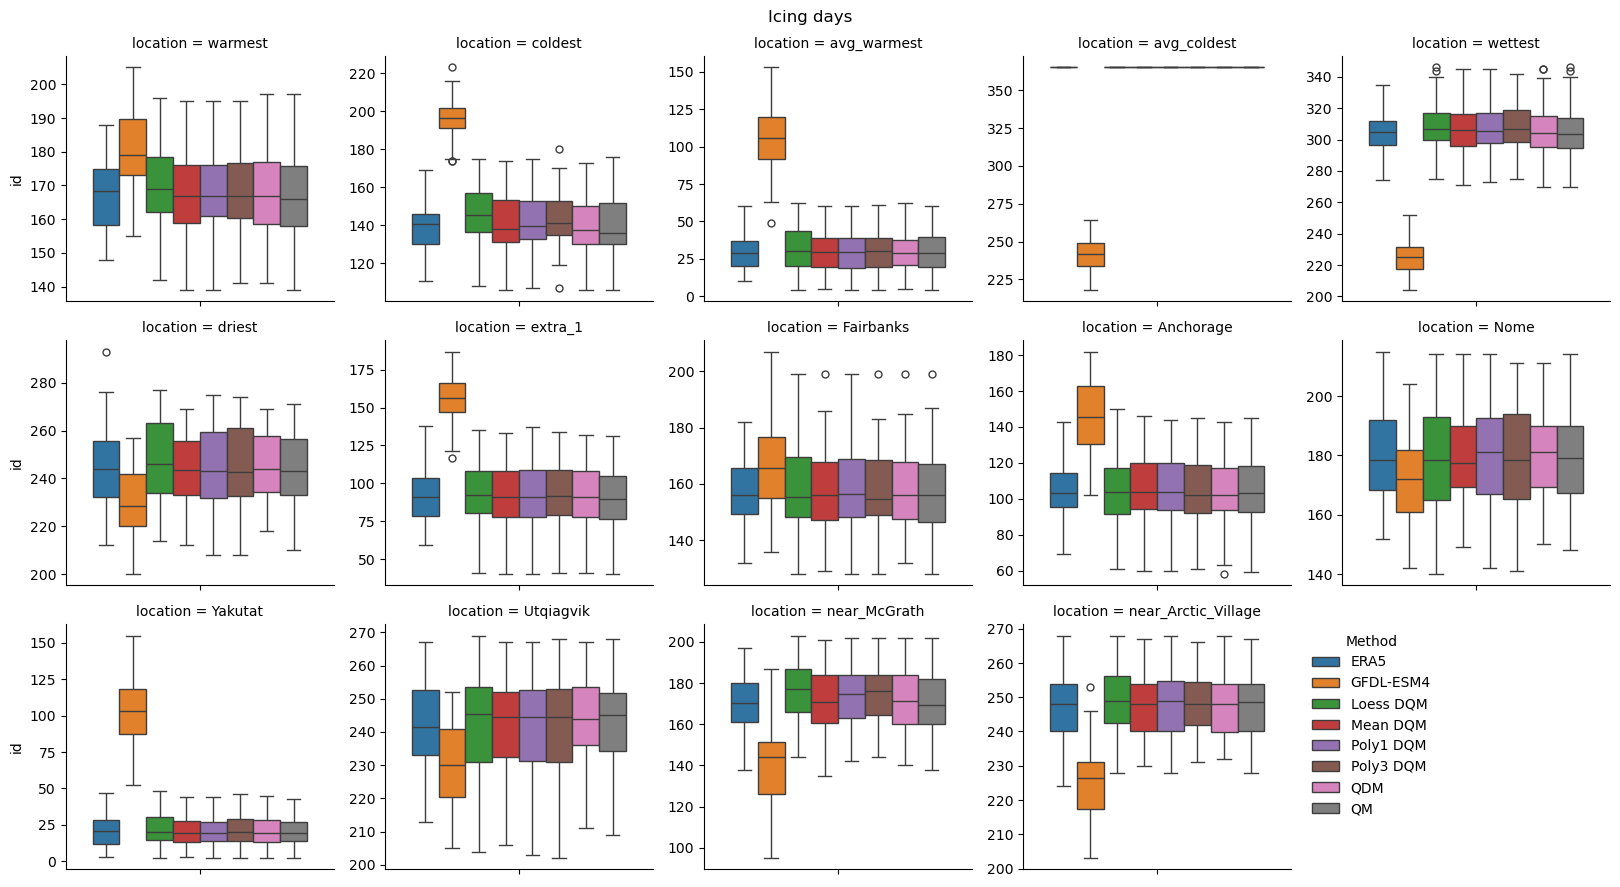

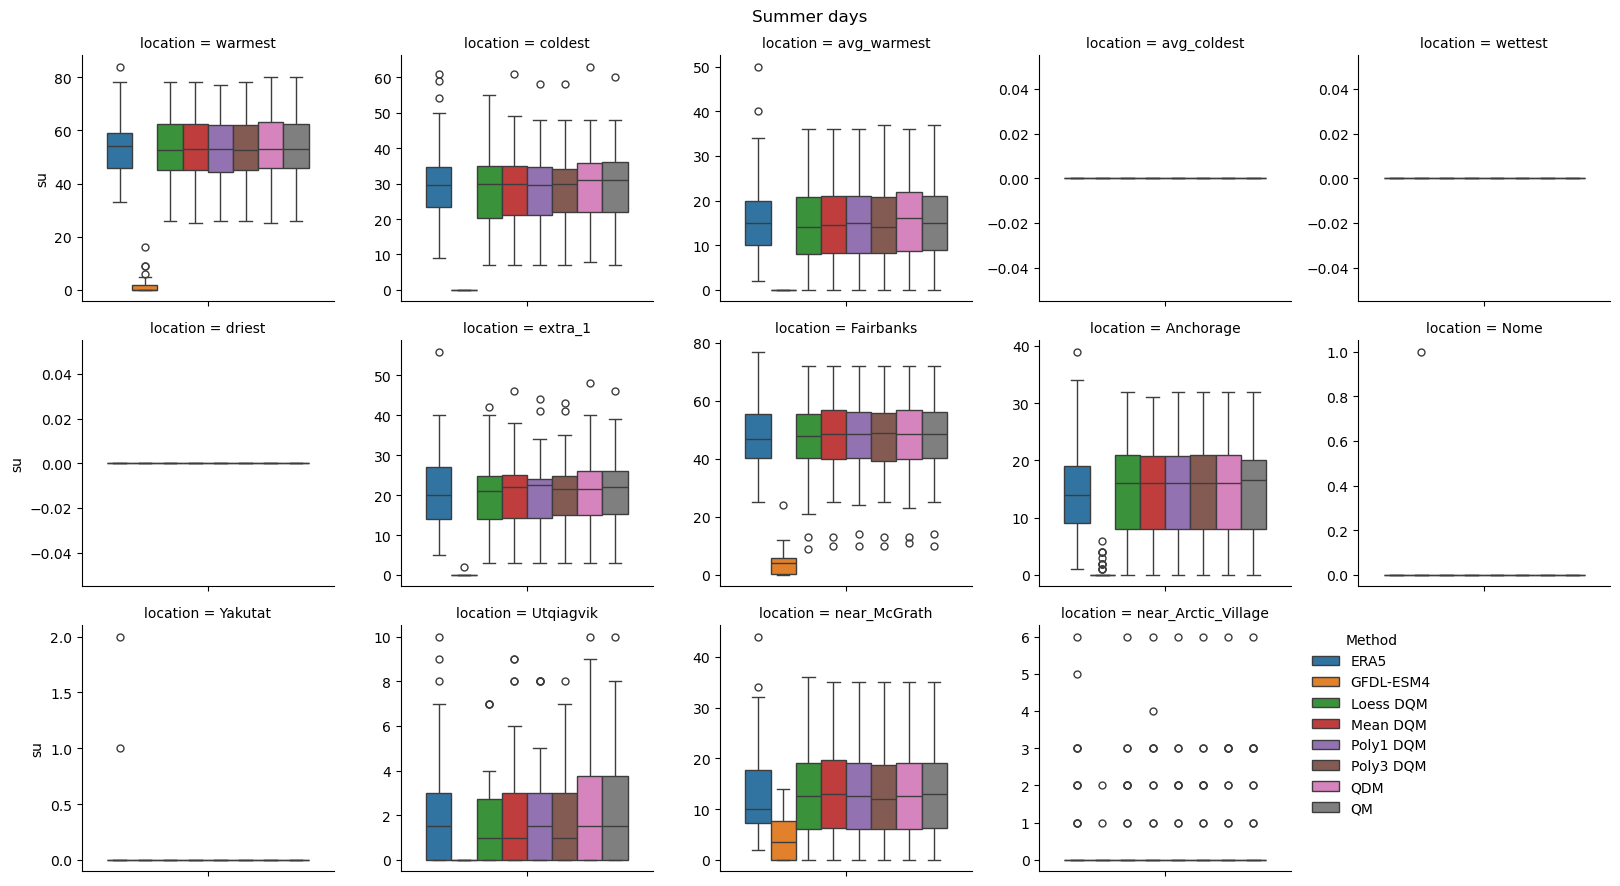

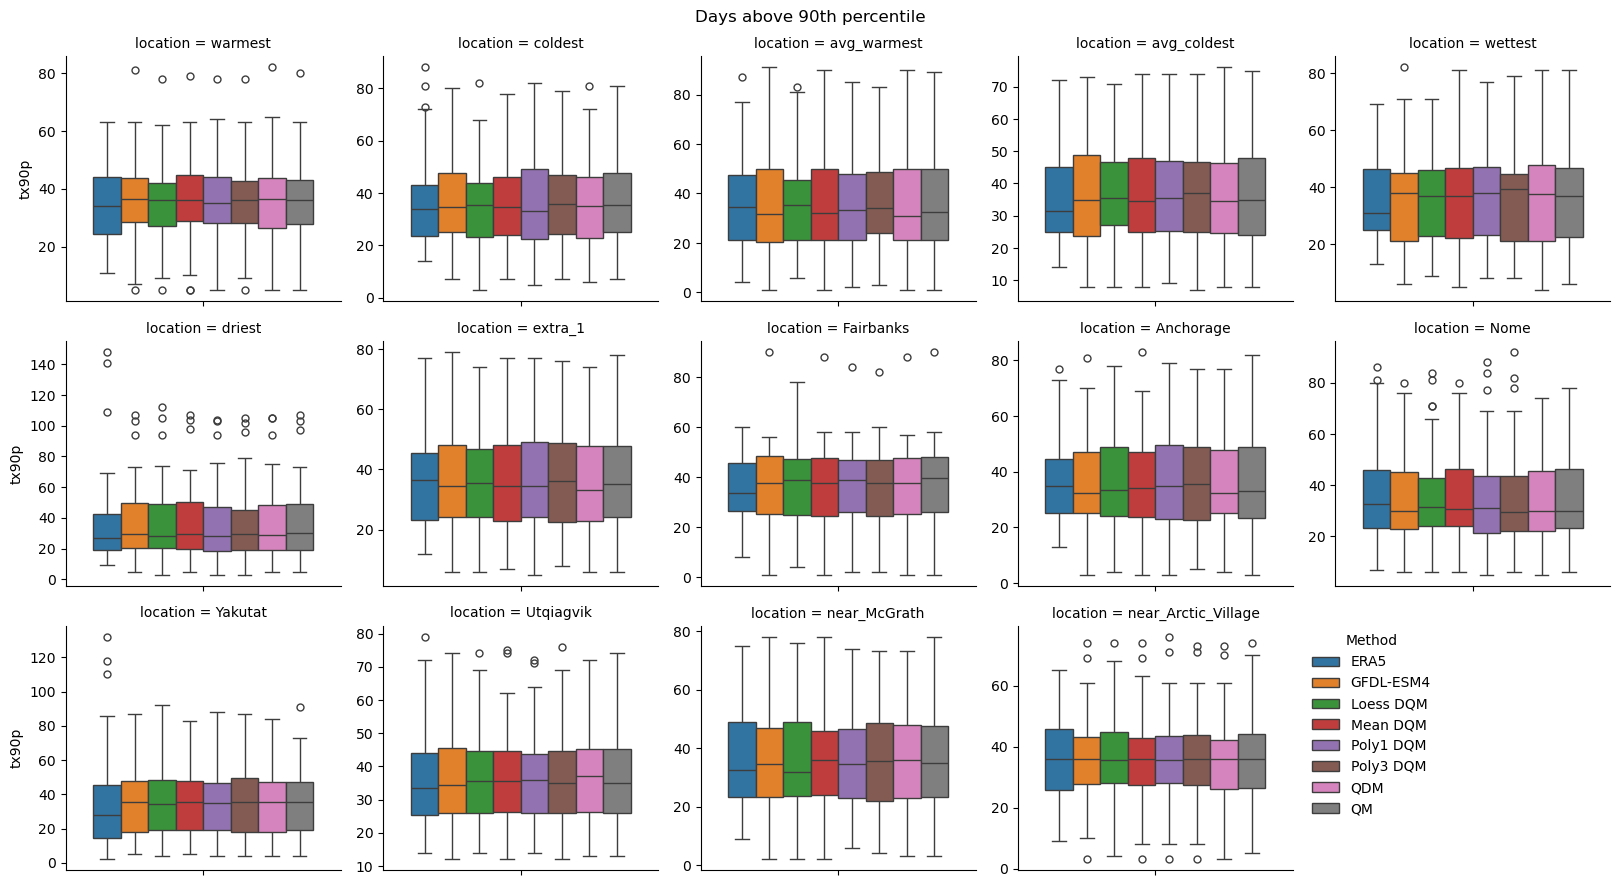

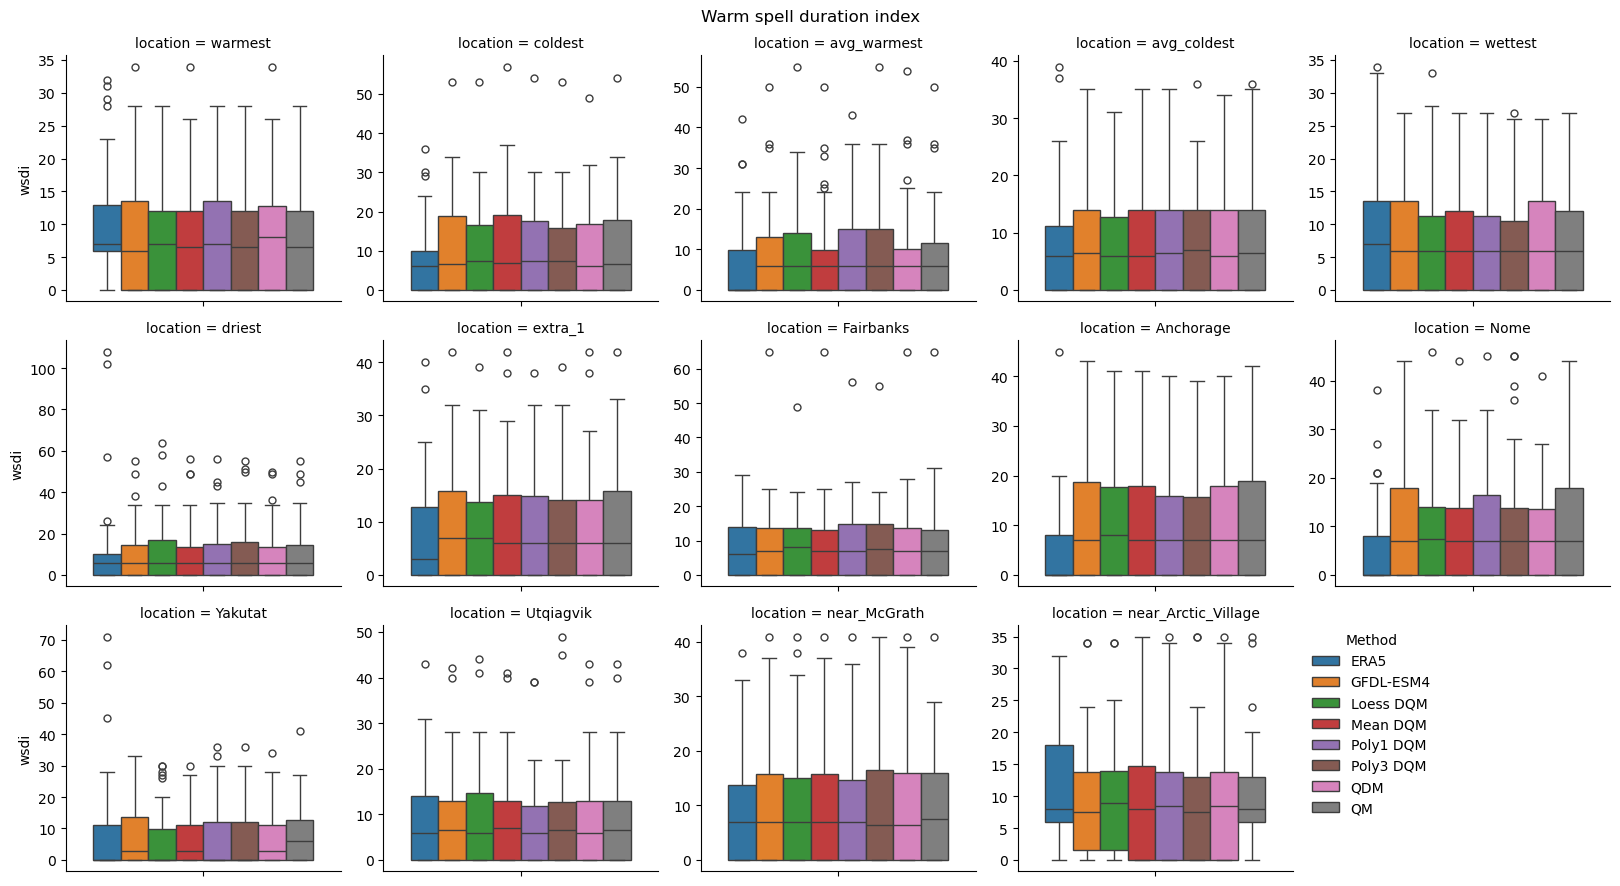

In [17]:
indicator_ds = results[model][var_id]["indicators"]["historical"]
for indicator in indicator_ds.data_vars:
    baeda.indicator_boxplot_by_location(indicator_ds, indicator)

### Precipitation

In [18]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"

hist_extr, sim_extr = baeda.extract_time_series_from_zarr(
    zarr_dir, model, scenario, var_id, coords
)
_ = hist_extr.load(), sim_extr.load()
results = baeda.run_full_adjustment_and_summarize(
    hist_extr, sim_extr, era5_extr[var_id], results
)

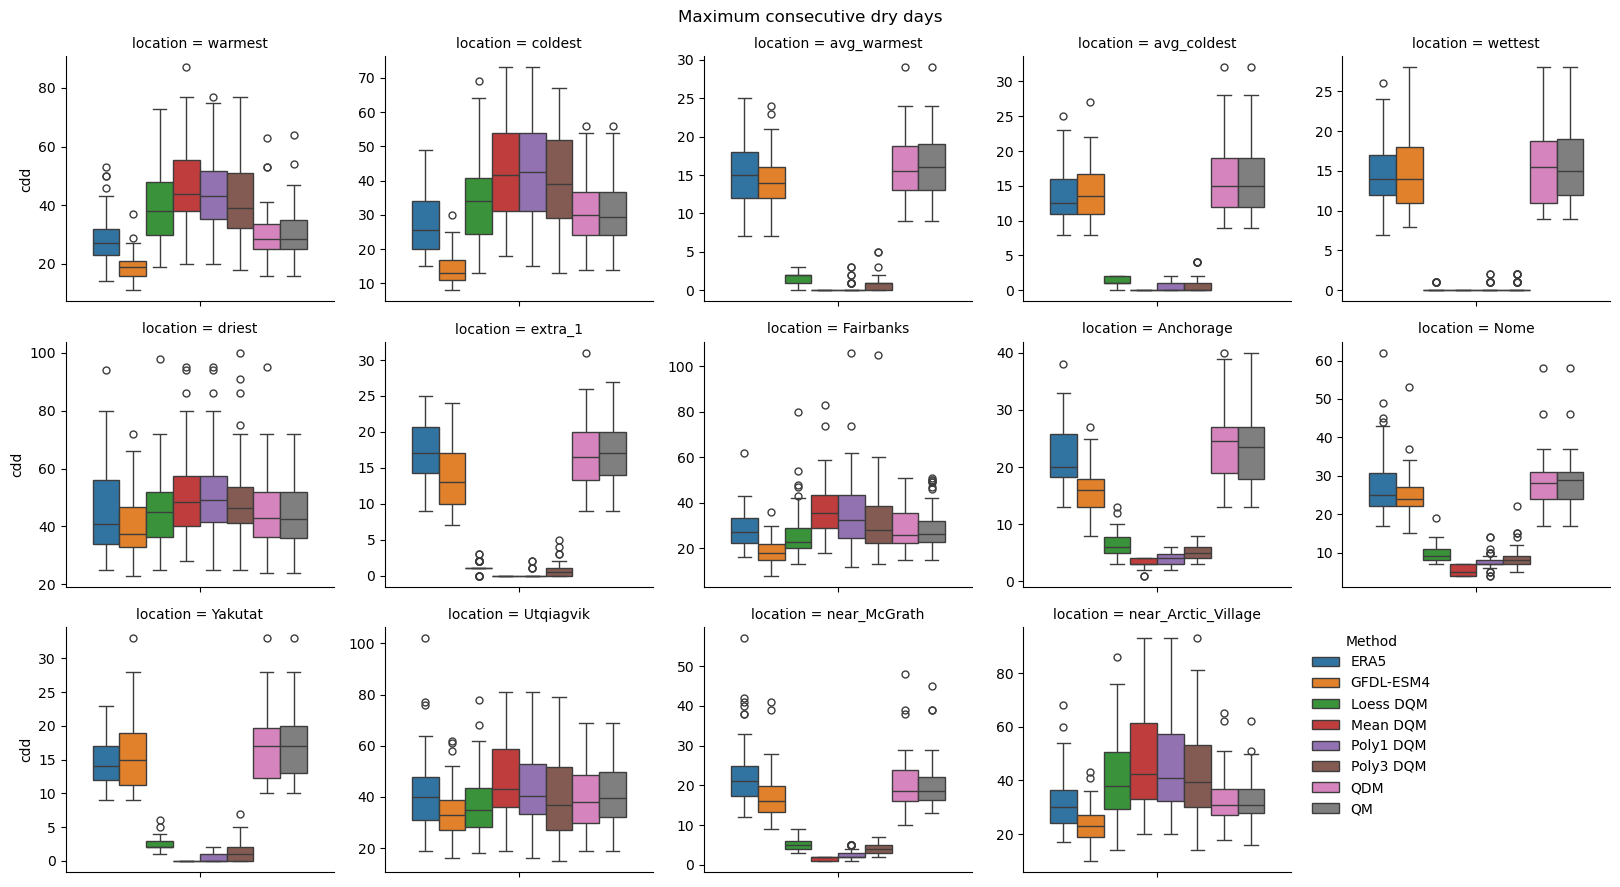

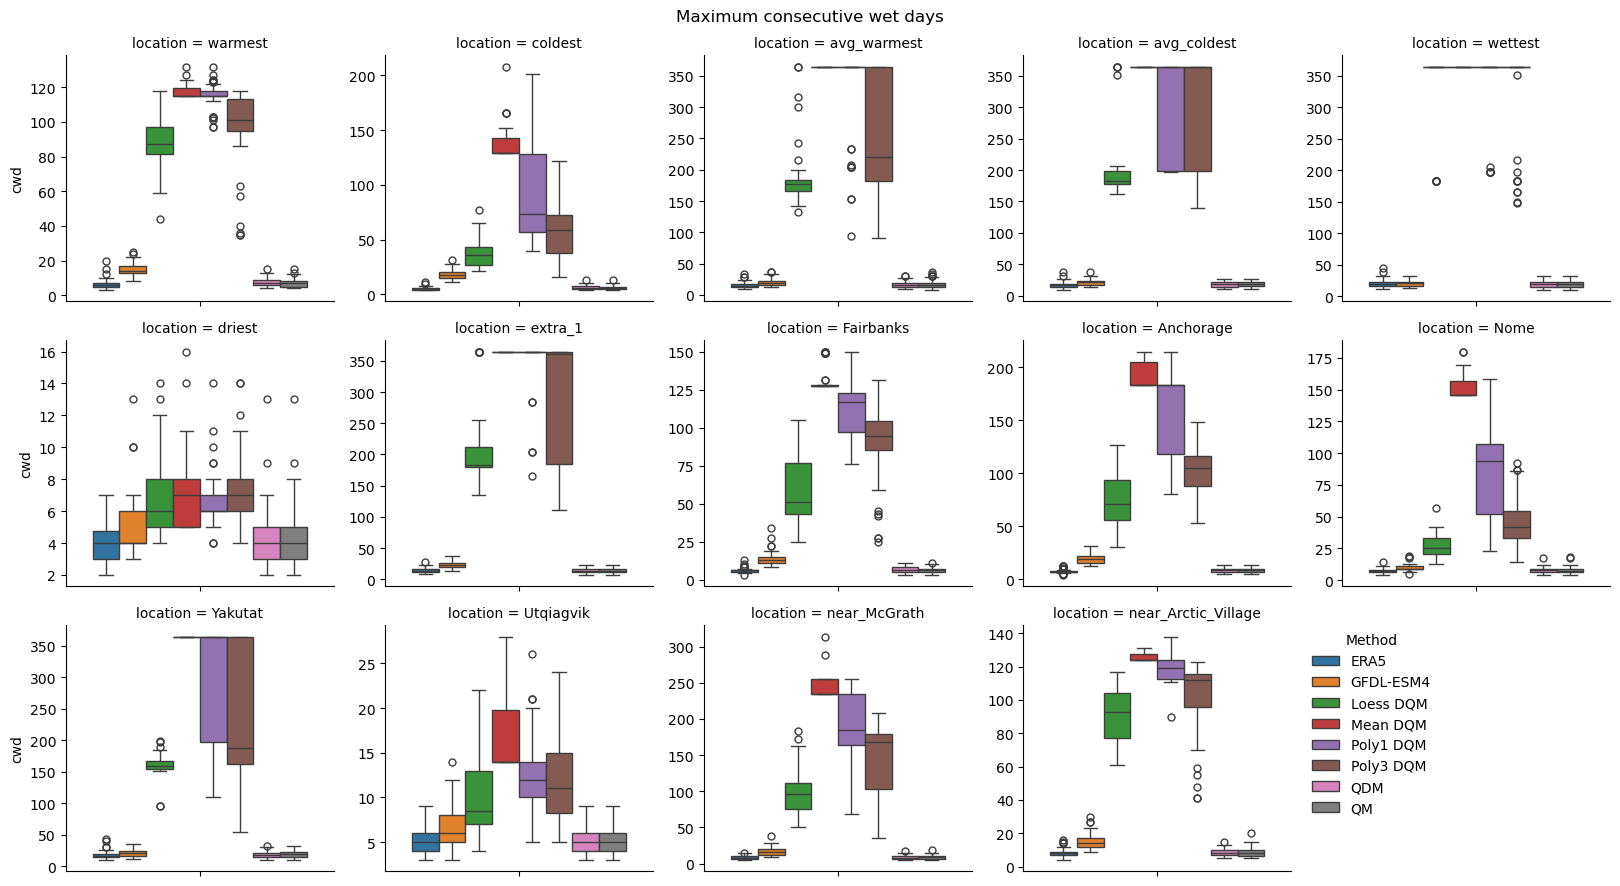

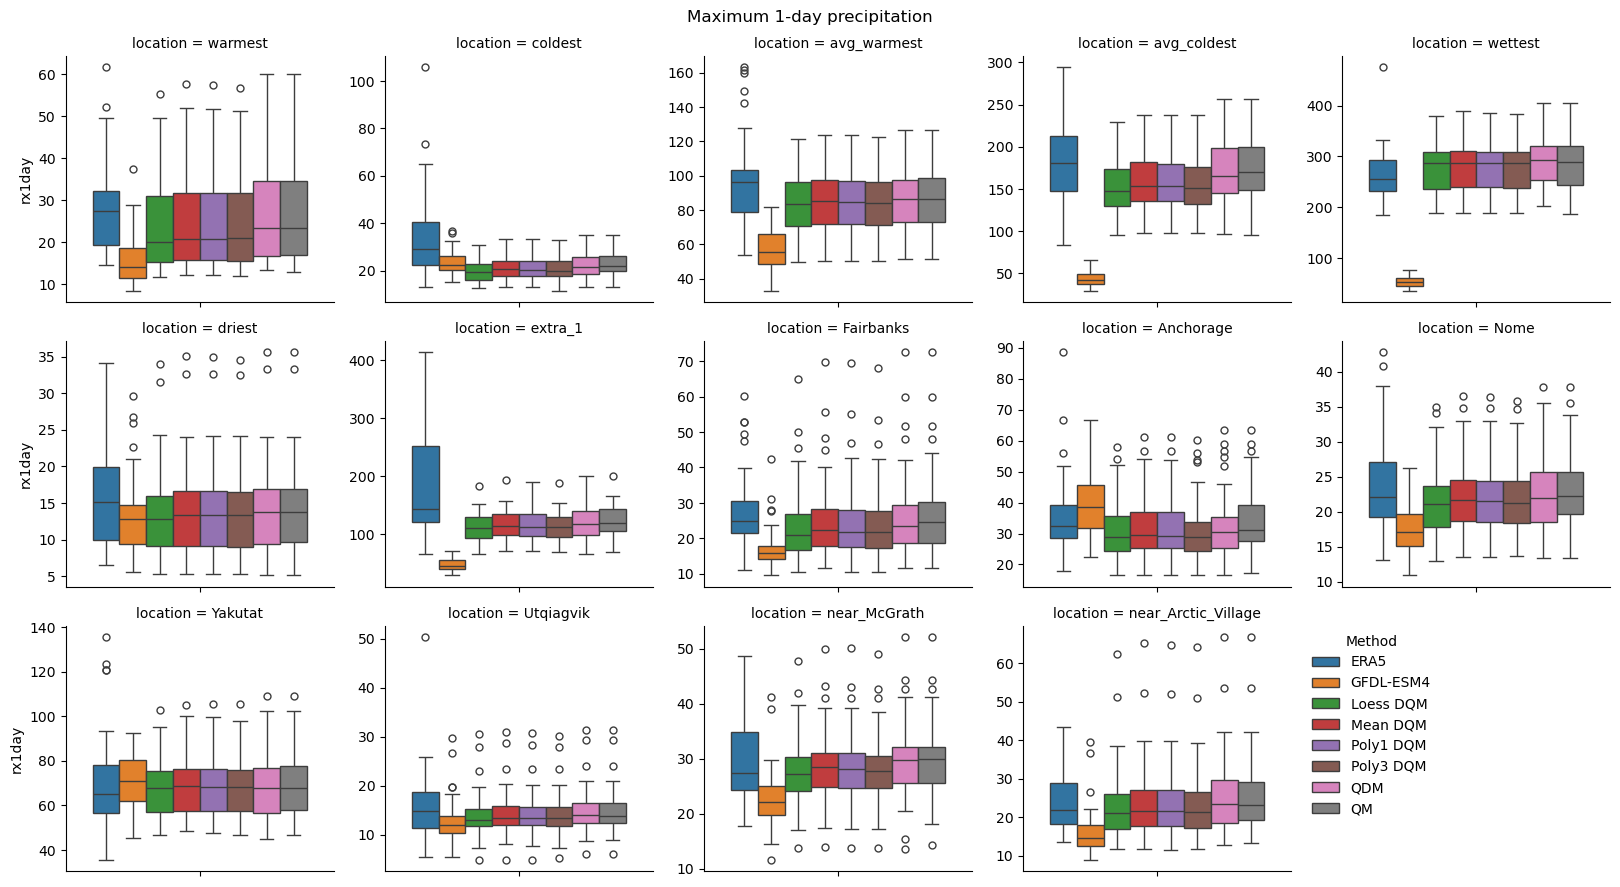

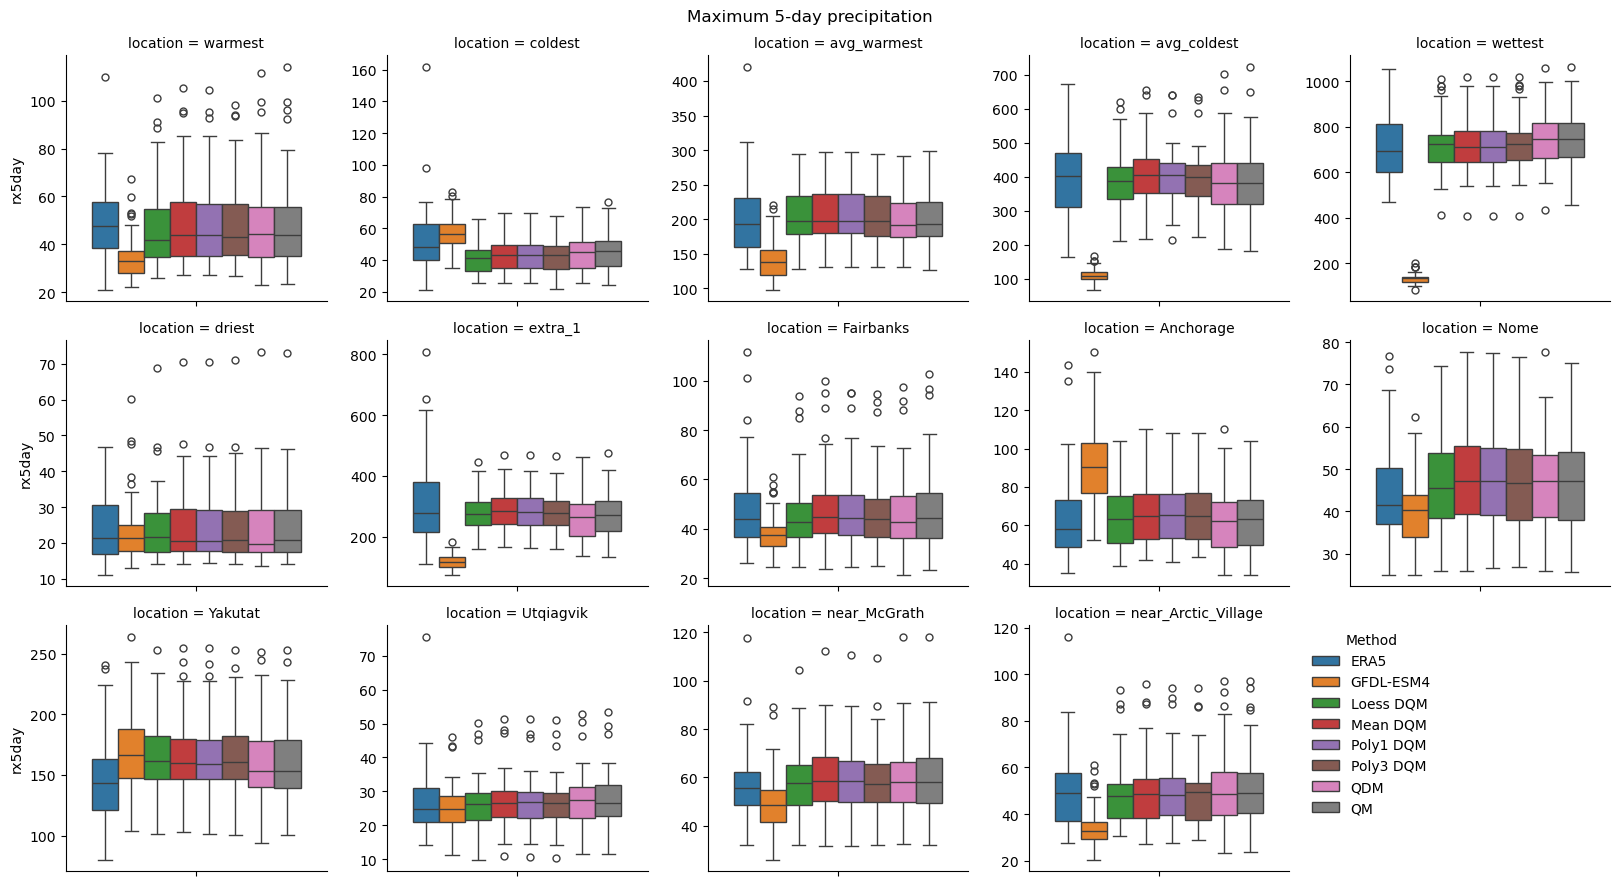

In [19]:
indicator_ds = results[model][var_id]["indicators"]["historical"]
for indicator in indicator_ds.data_vars:
    baeda.indicator_boxplot_by_location(indicator_ds, indicator)

### Seasonal cycles

#### Maximum temperature cycles

Here we will summarise precipitation to visualize the fidelity to the observed seasonal cycle. Assign the week-of-year to each observation and plot the mean +/- 95% CI:

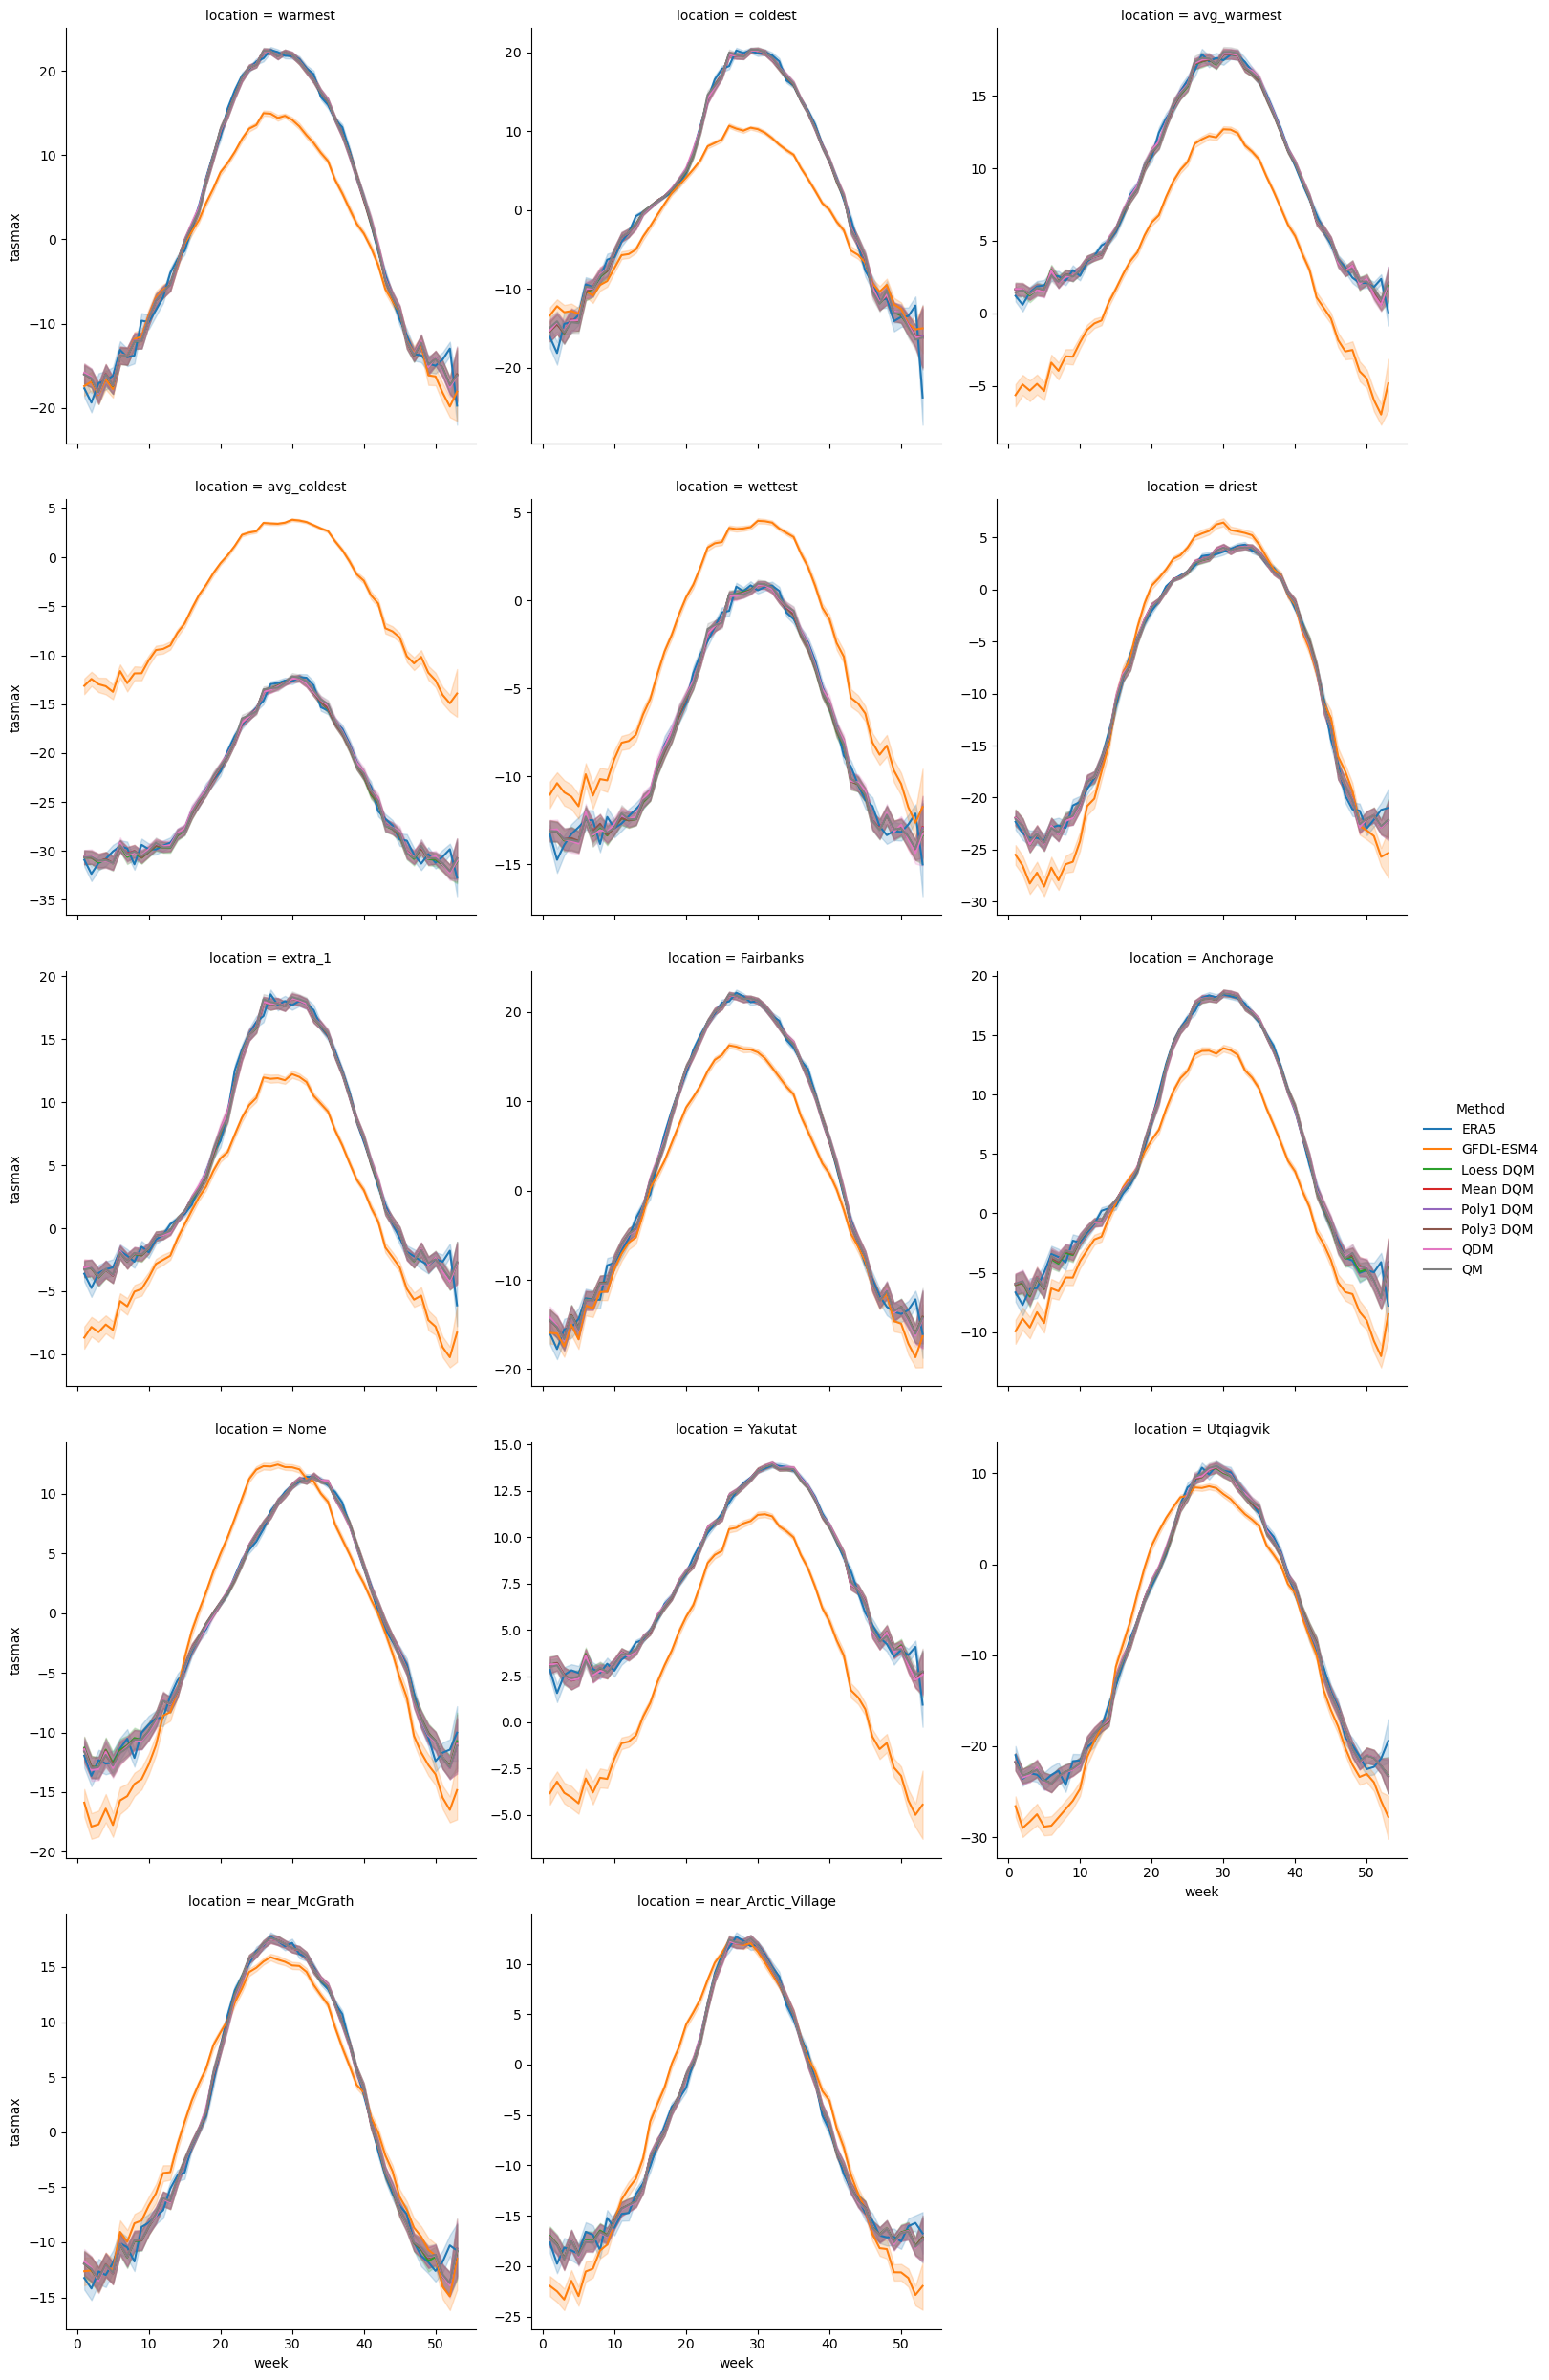

In [20]:
var_id = "tasmax"
week = (
    results[model][var_id]["adj"]["historical"]
    .convert_calendar("standard")
    .time.dt.isocalendar()
    .week.convert_calendar("noleap")
)
df = (
    results[model][var_id]["adj"]["historical"]
    .assign_coords(week=week)
    .to_dataframe()
    .reset_index()
)
era5_df = (
    era5_extr[var_id]
    .assign_coords(Method="ERA5", week=week)
    .to_dataframe()
    .reset_index()
)
df = pd.concat([era5_df, df])

sns.relplot(
    data=df,
    x="week",
    y=var_id,
    hue="Method",
    kind="line",
    col="location",
    col_wrap=3,
    facet_kws={"sharey": False},
)

#### Precipitation cycles

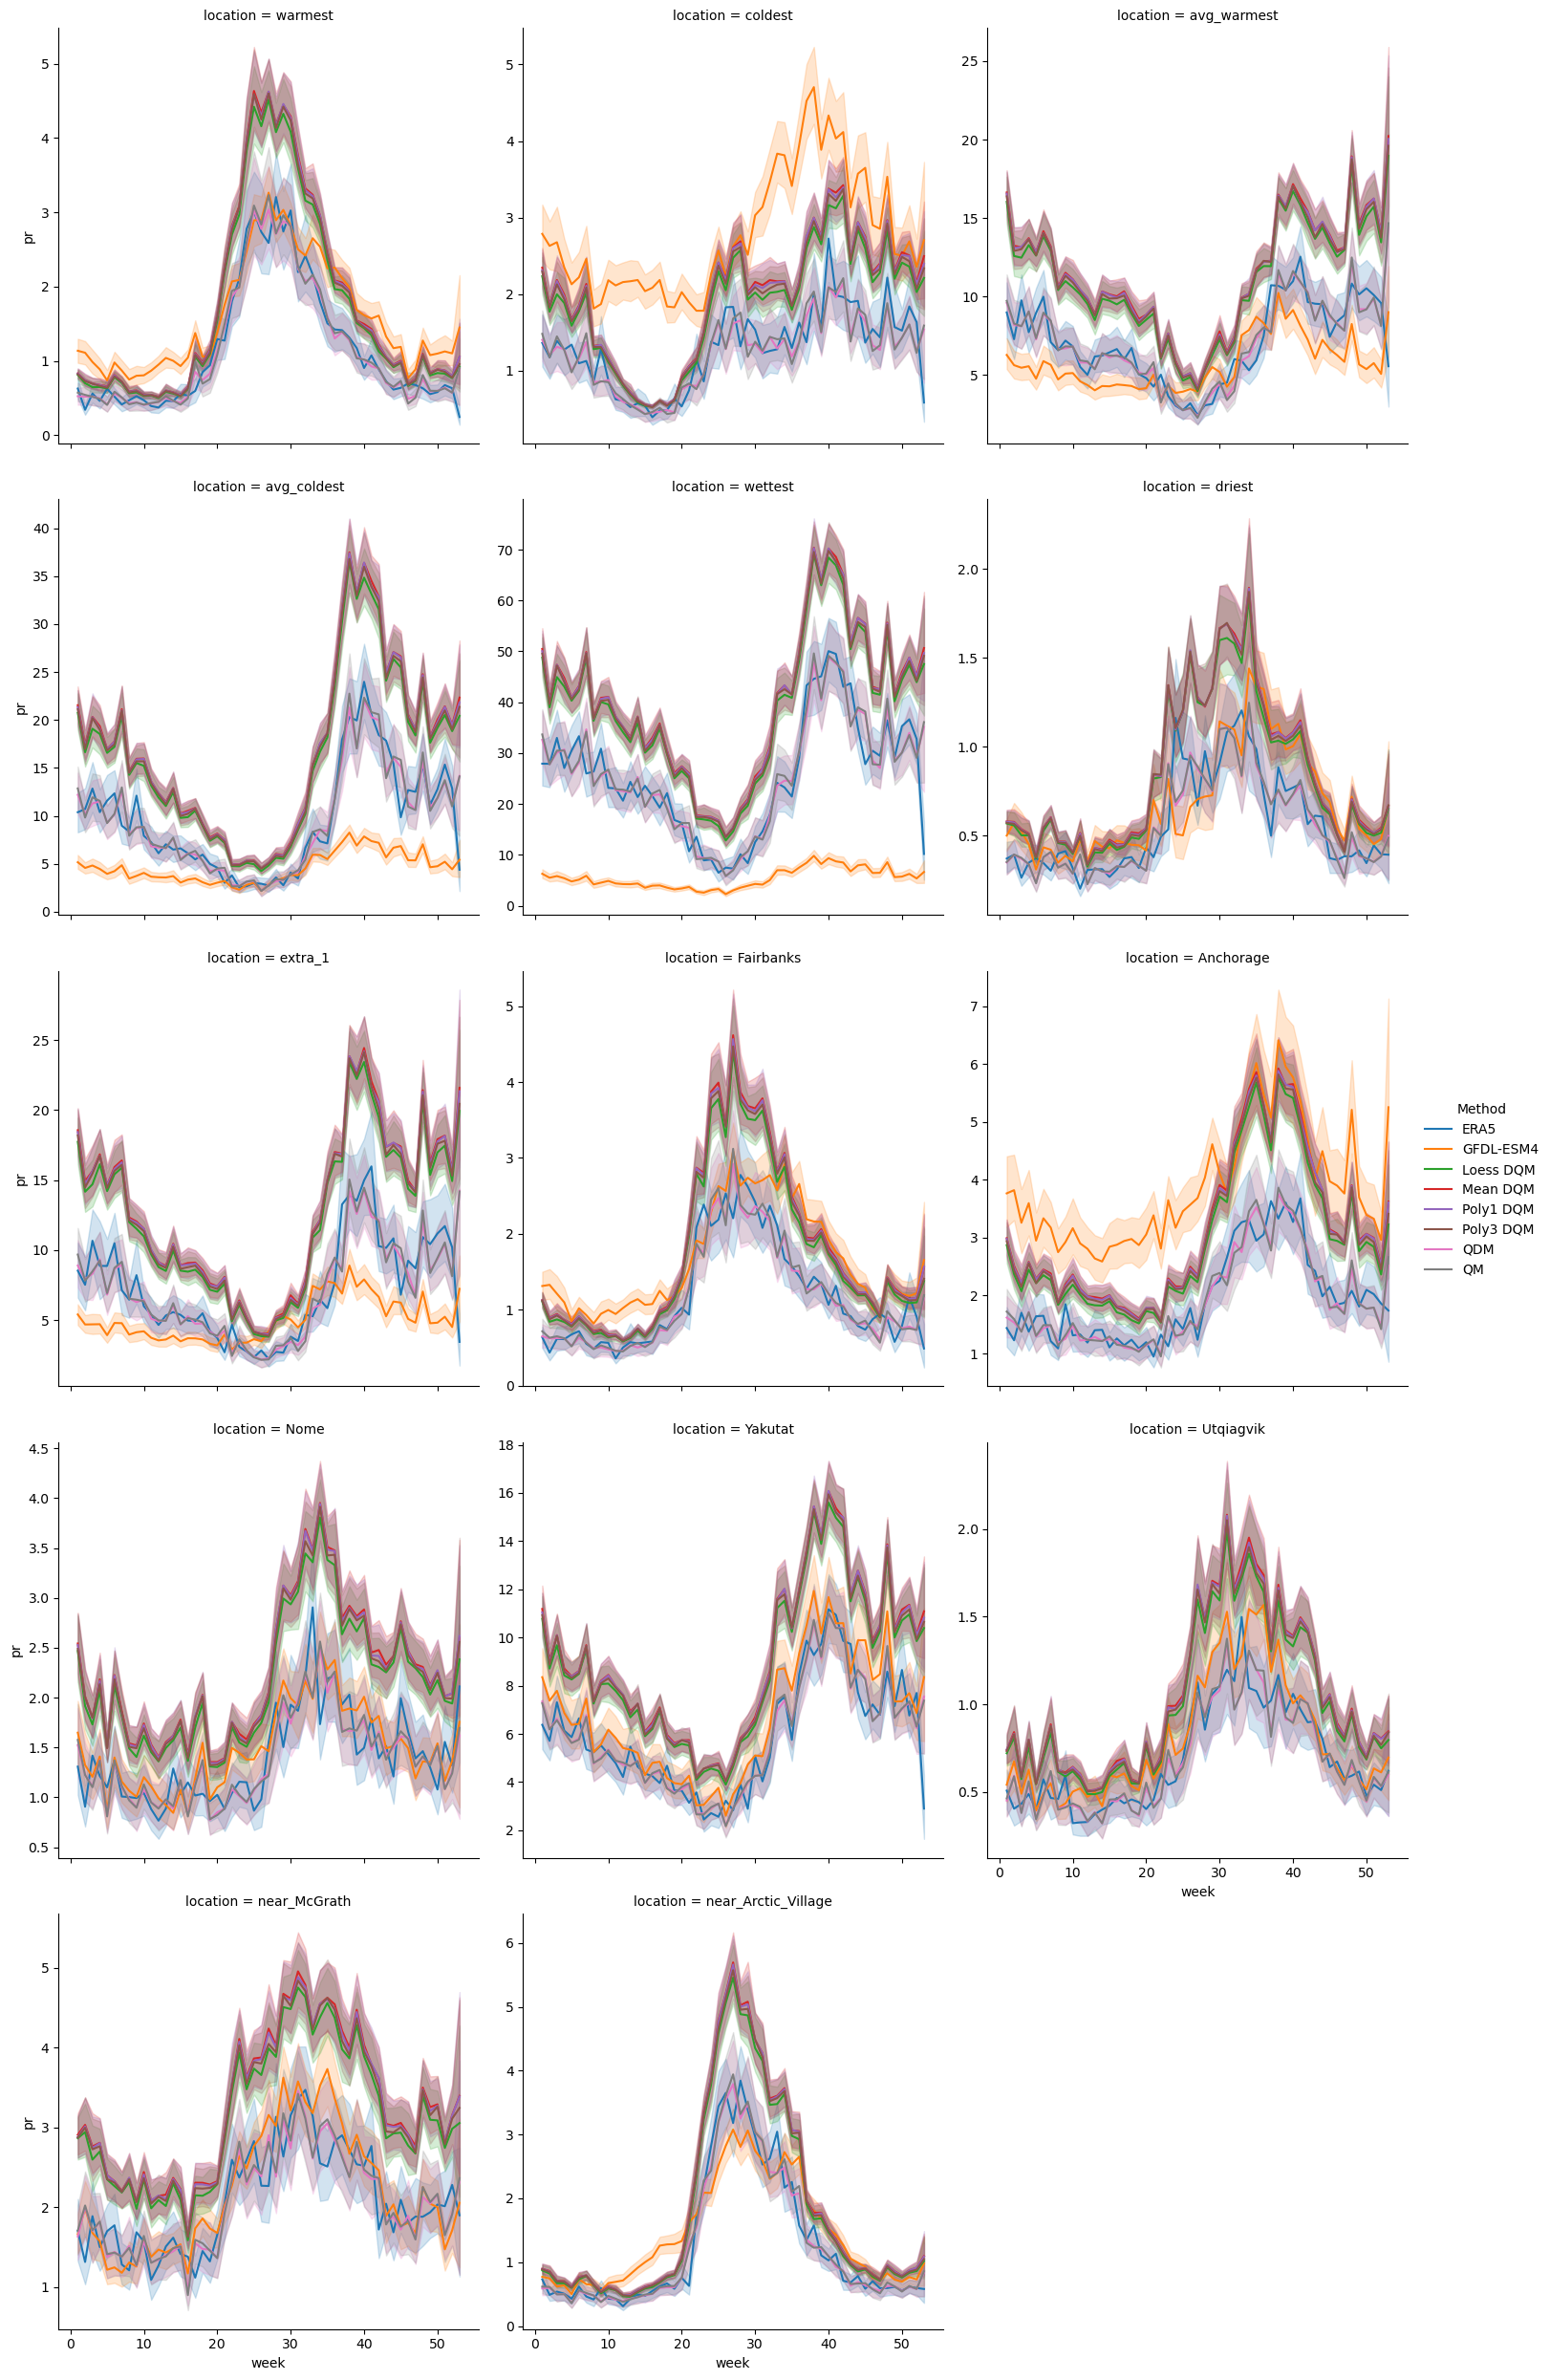

In [21]:
var_id = "pr"
week = (
    results[model][var_id]["adj"]["historical"]
    .convert_calendar("standard")
    .time.dt.isocalendar()
    .week.convert_calendar("noleap")
)
df = (
    results[model][var_id]["adj"]["historical"]
    .assign_coords(week=week)
    .to_dataframe()
    .reset_index()
)
era5_df = (
    era5_extr[var_id]
    .assign_coords(Method="ERA5", week=week)
    .to_dataframe()
    .reset_index()
)
df = pd.concat([era5_df, df])

sns.relplot(
    data=df,
    x="week",
    y=var_id,
    hue="Method",
    kind="line",
    col="location",
    col_wrap=3,
    facet_kws={"sharey": False},
)

### Trends

Here we will simply plot the trends via annual means over the whole historical time series.

#### Maximum temperature trends

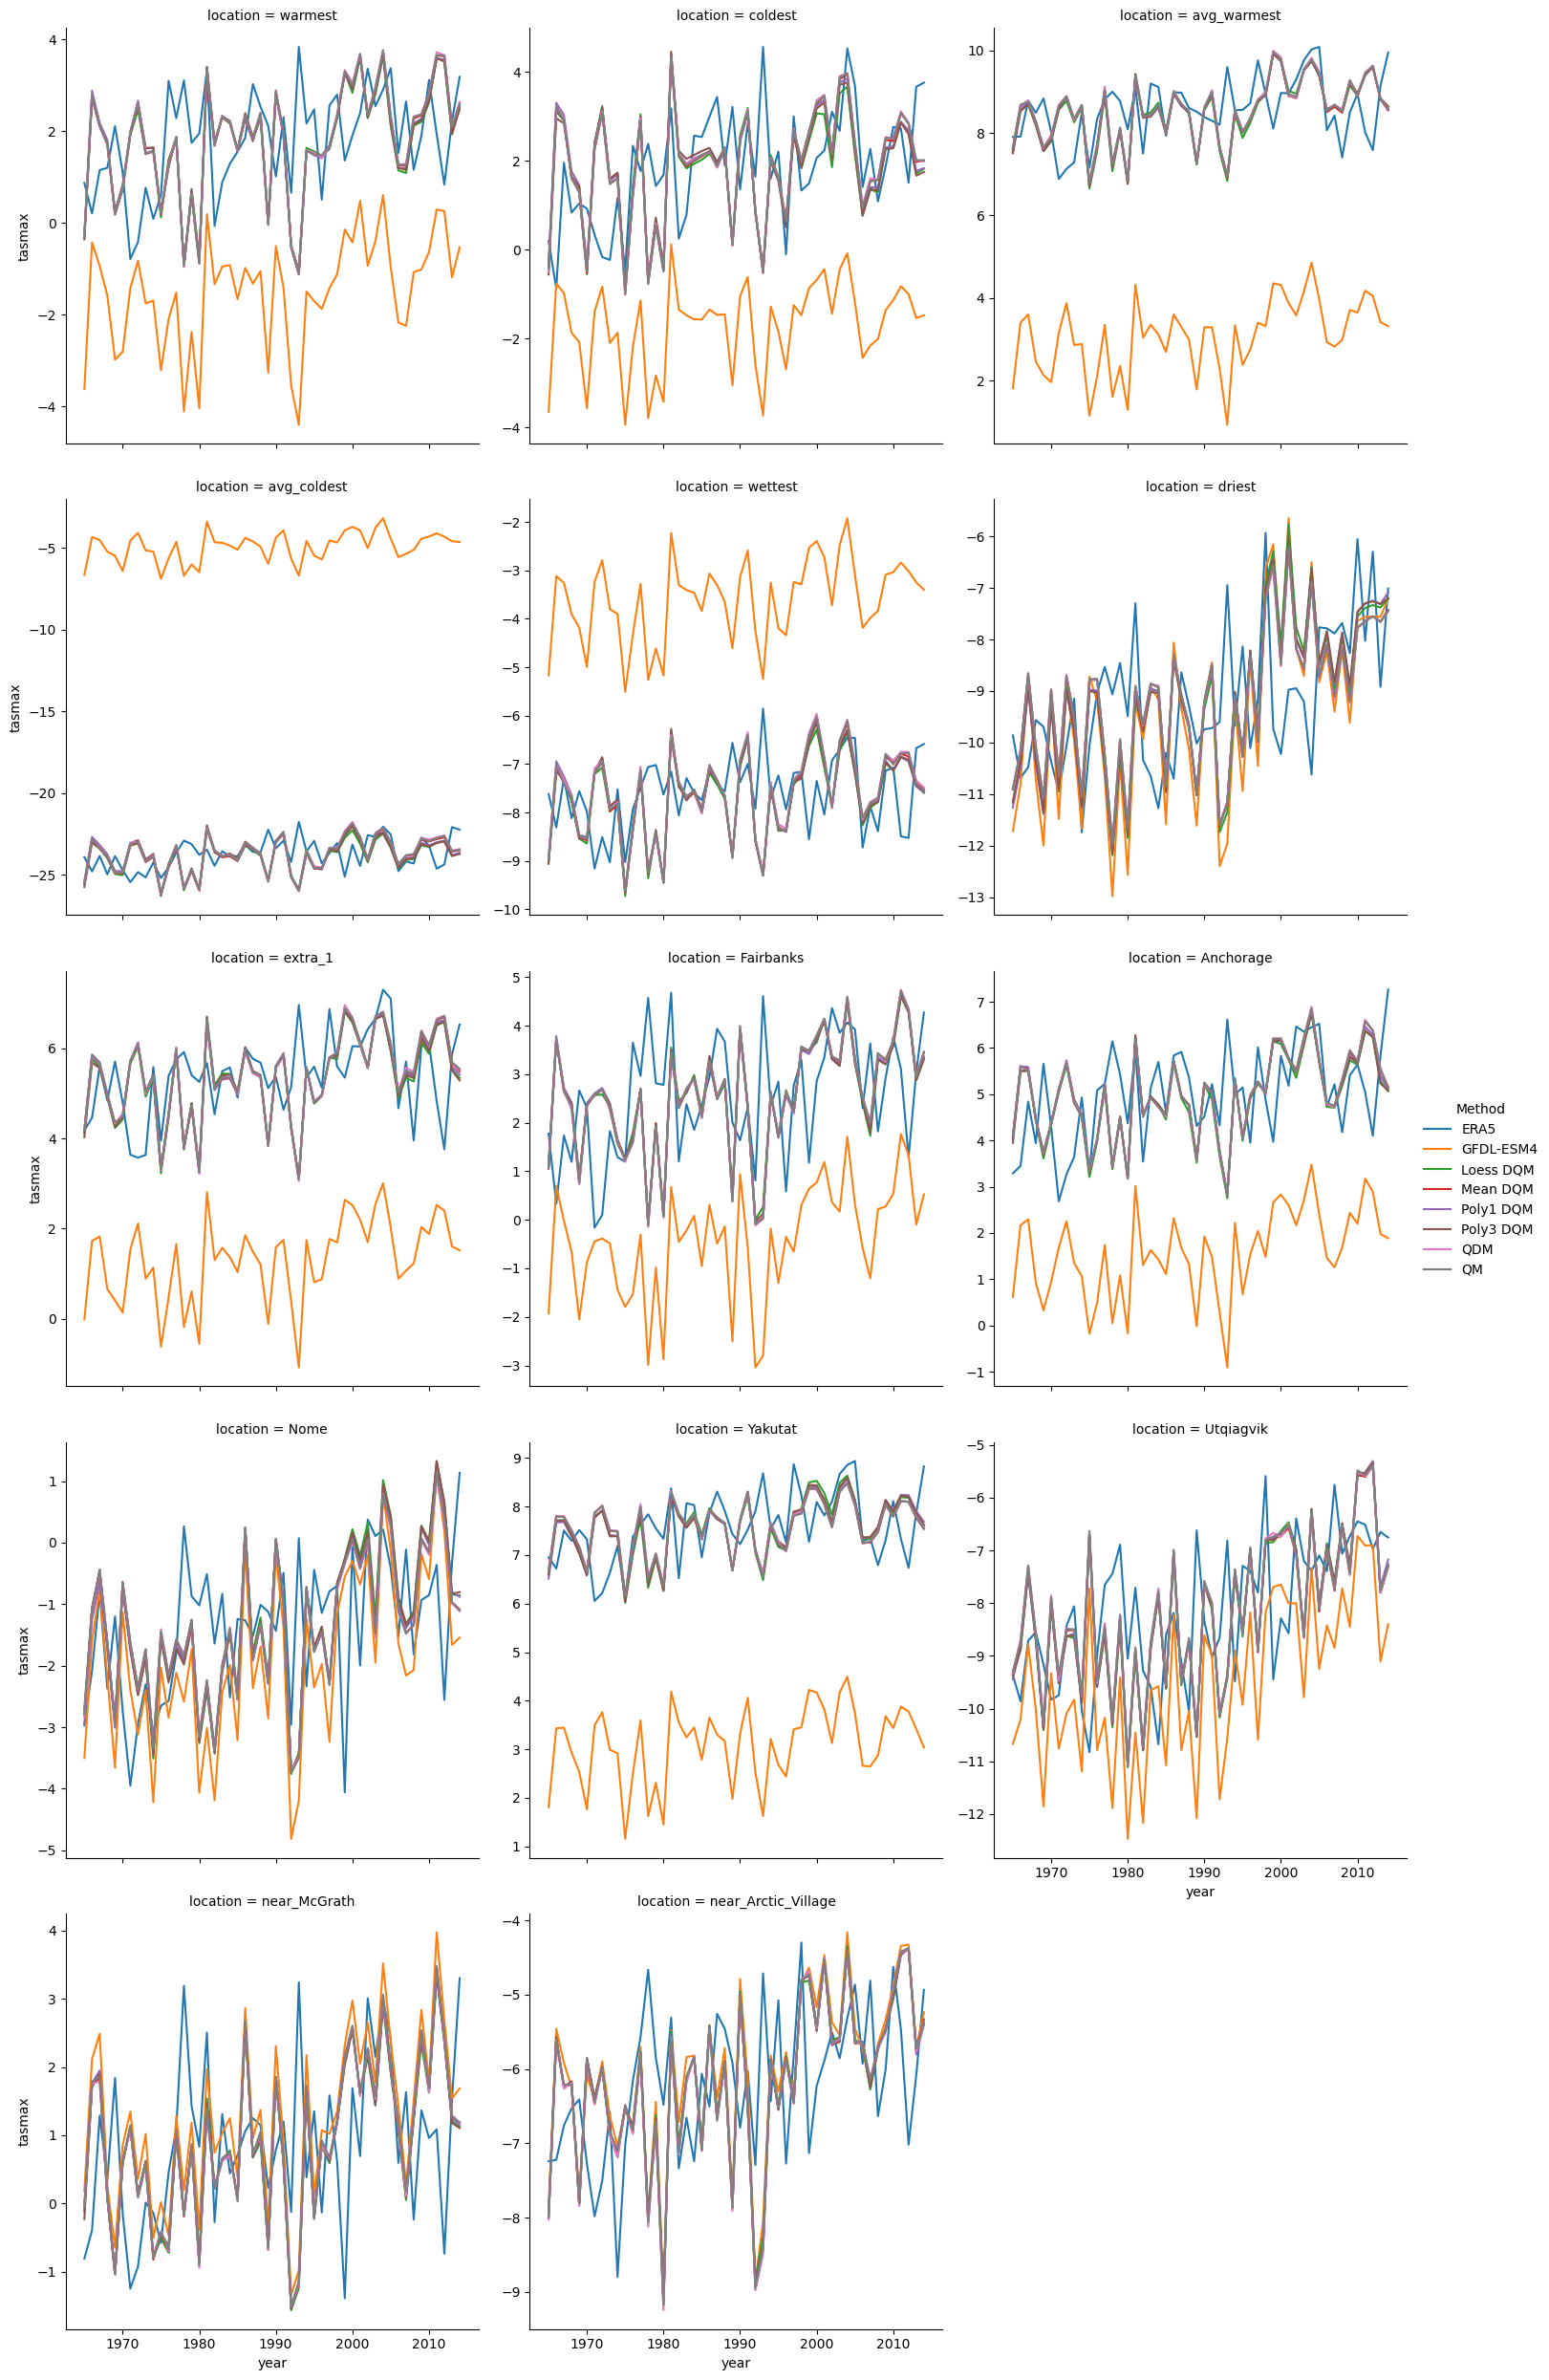

In [22]:
var_id = "tasmax"
df = (
    results[model][var_id]["adj"]["historical"]
    .groupby("time.year")
    .mean()
    .to_dataframe()
    .reset_index()
)
era5_df = (
    era5_extr[var_id]
    .groupby("time.year")
    .mean()
    .assign_coords(Method="ERA5")
    .to_dataframe()
    .reset_index()
)
df = pd.concat([era5_df, df])
sns.relplot(
    data=df,
    x="year",
    y=var_id,
    hue="Method",
    kind="line",
    col="location",
    col_wrap=3,
    facet_kws={"sharey": False},
)

#### Precipitation trends

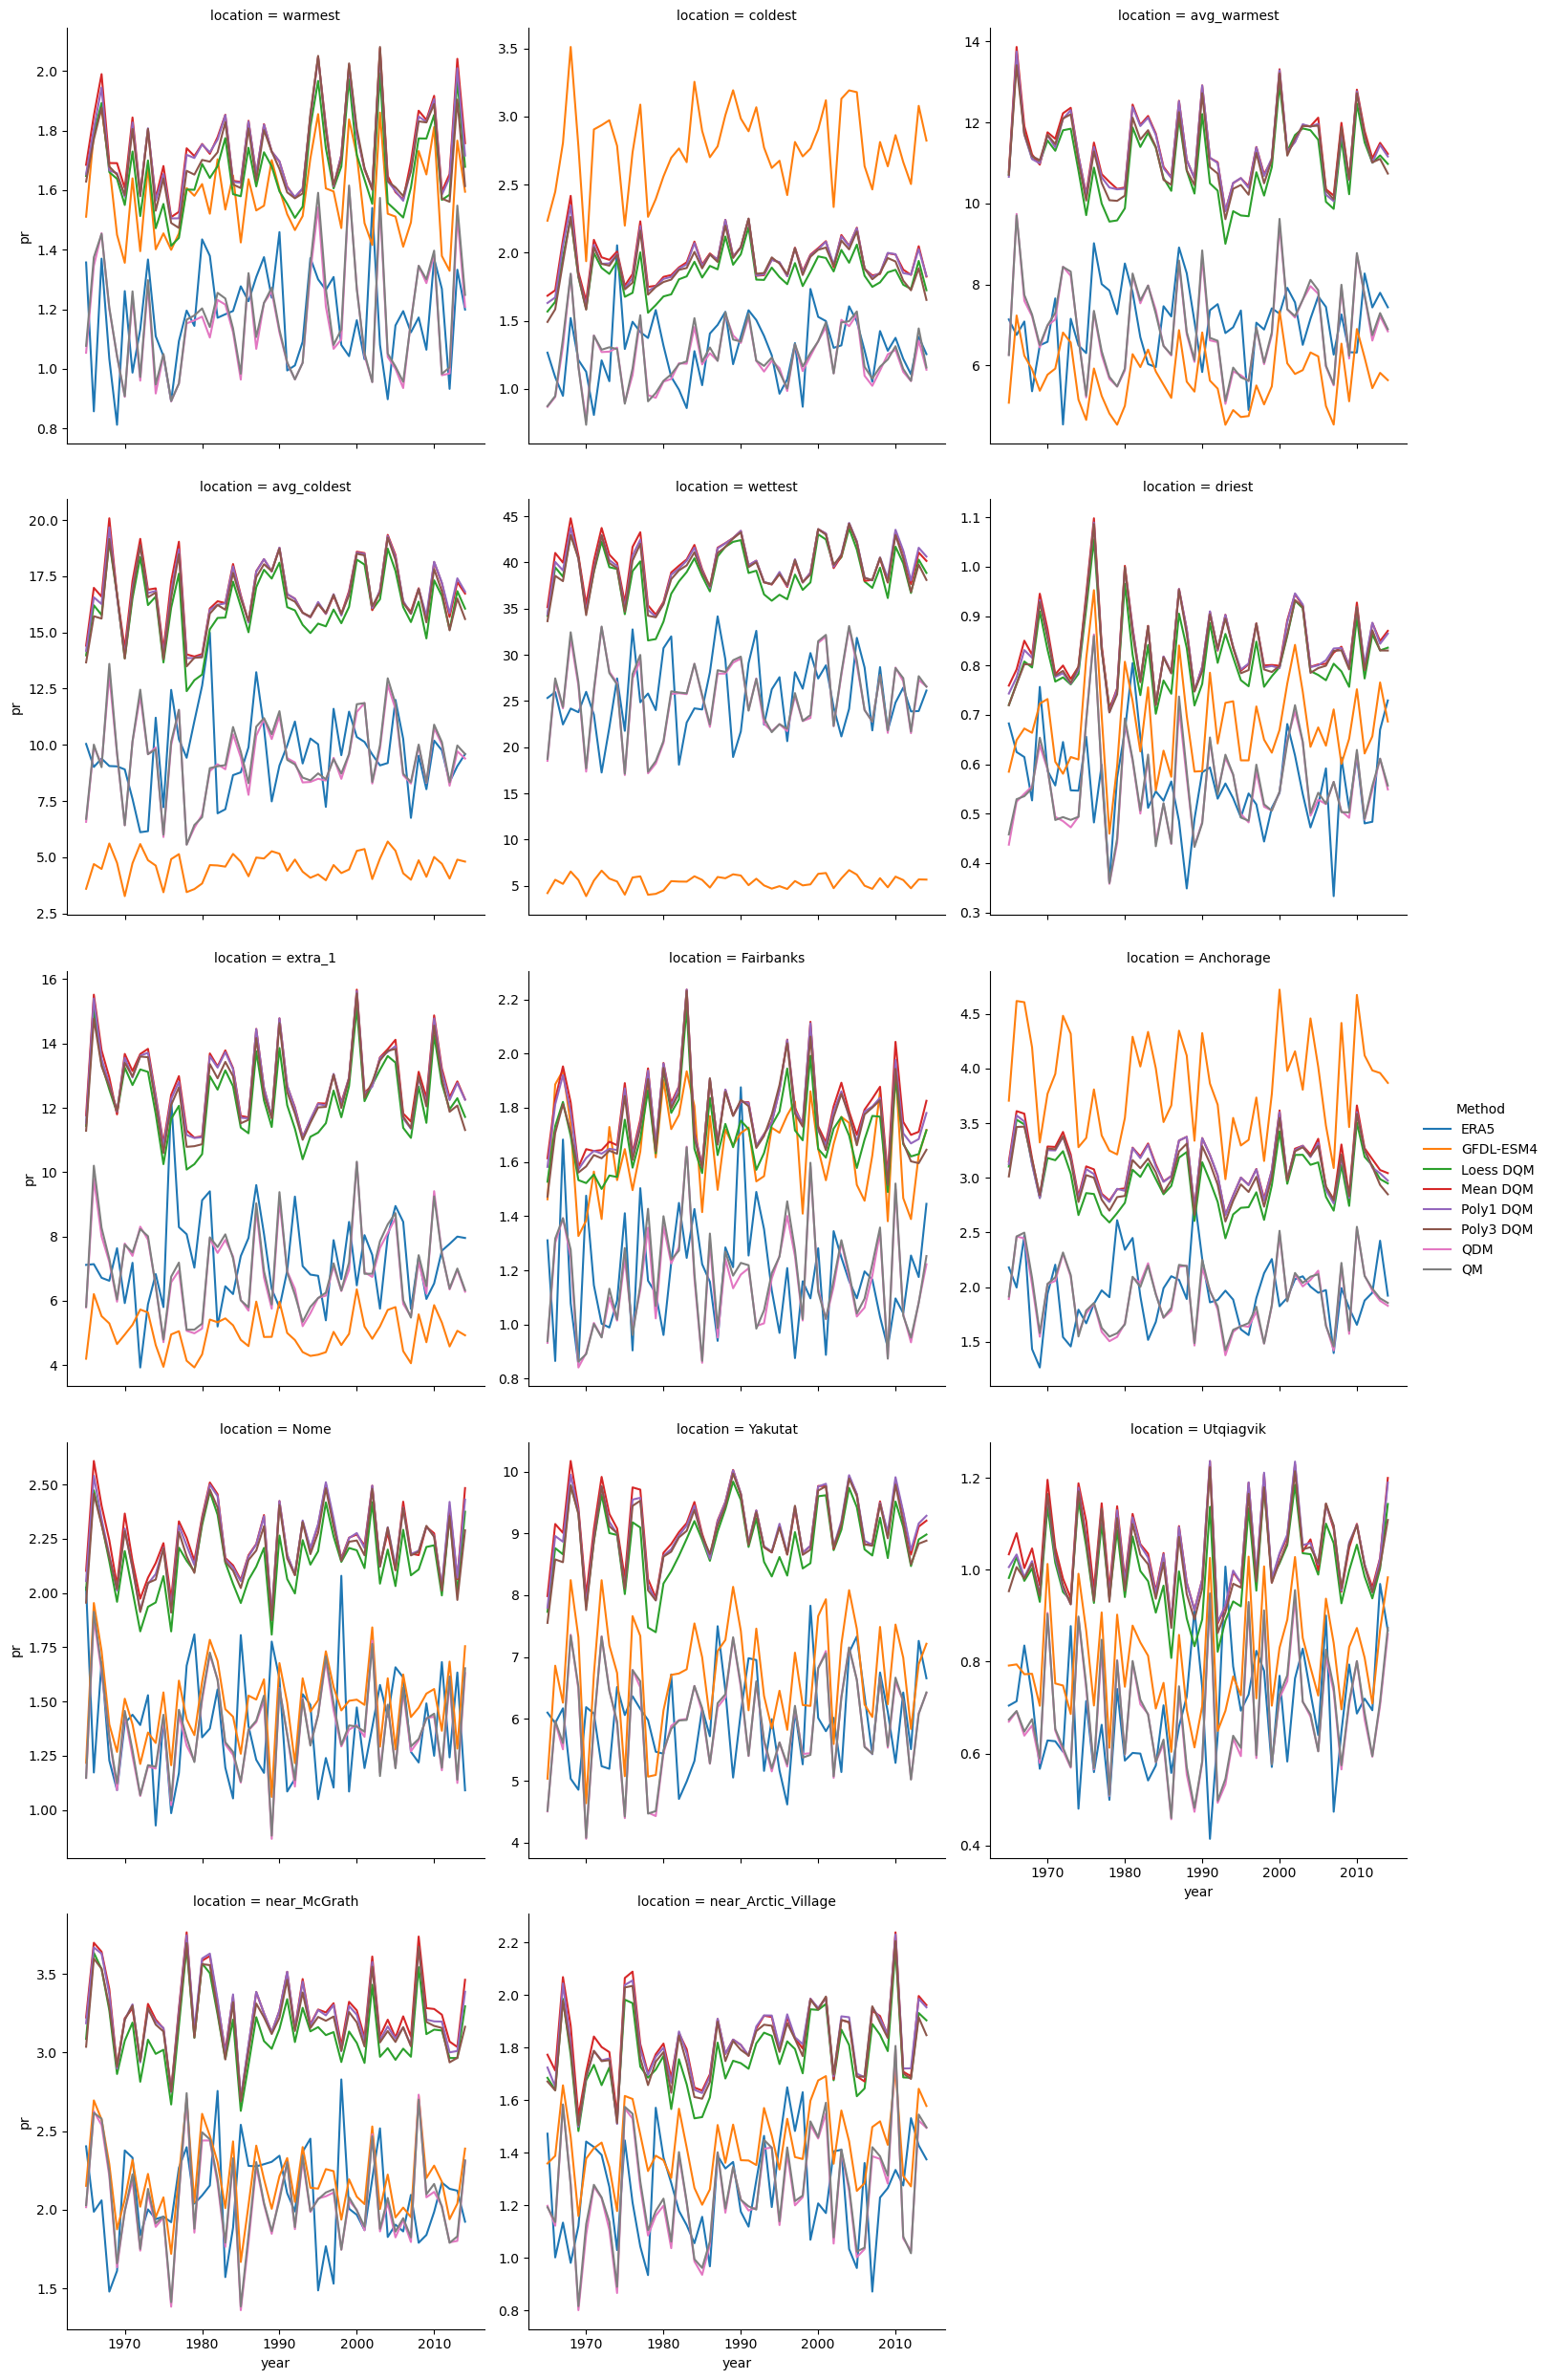

In [23]:
var_id = "pr"
df = (
    results[model][var_id]["adj"]["historical"]
    .groupby("time.year")
    .mean()
    .to_dataframe()
    .reset_index()
)
era5_df = (
    era5_extr[var_id]
    .groupby("time.year")
    .mean()
    .assign_coords(Method="ERA5")
    .to_dataframe()
    .reset_index()
)
df = pd.concat([era5_df, df])
sns.relplot(
    data=df,
    x="year",
    y=var_id,
    hue="Method",
    kind="line",
    col="location",
    col_wrap=3,
    facet_kws={"sharey": False},
)

## Preservation of projected change

### Maximum temperature

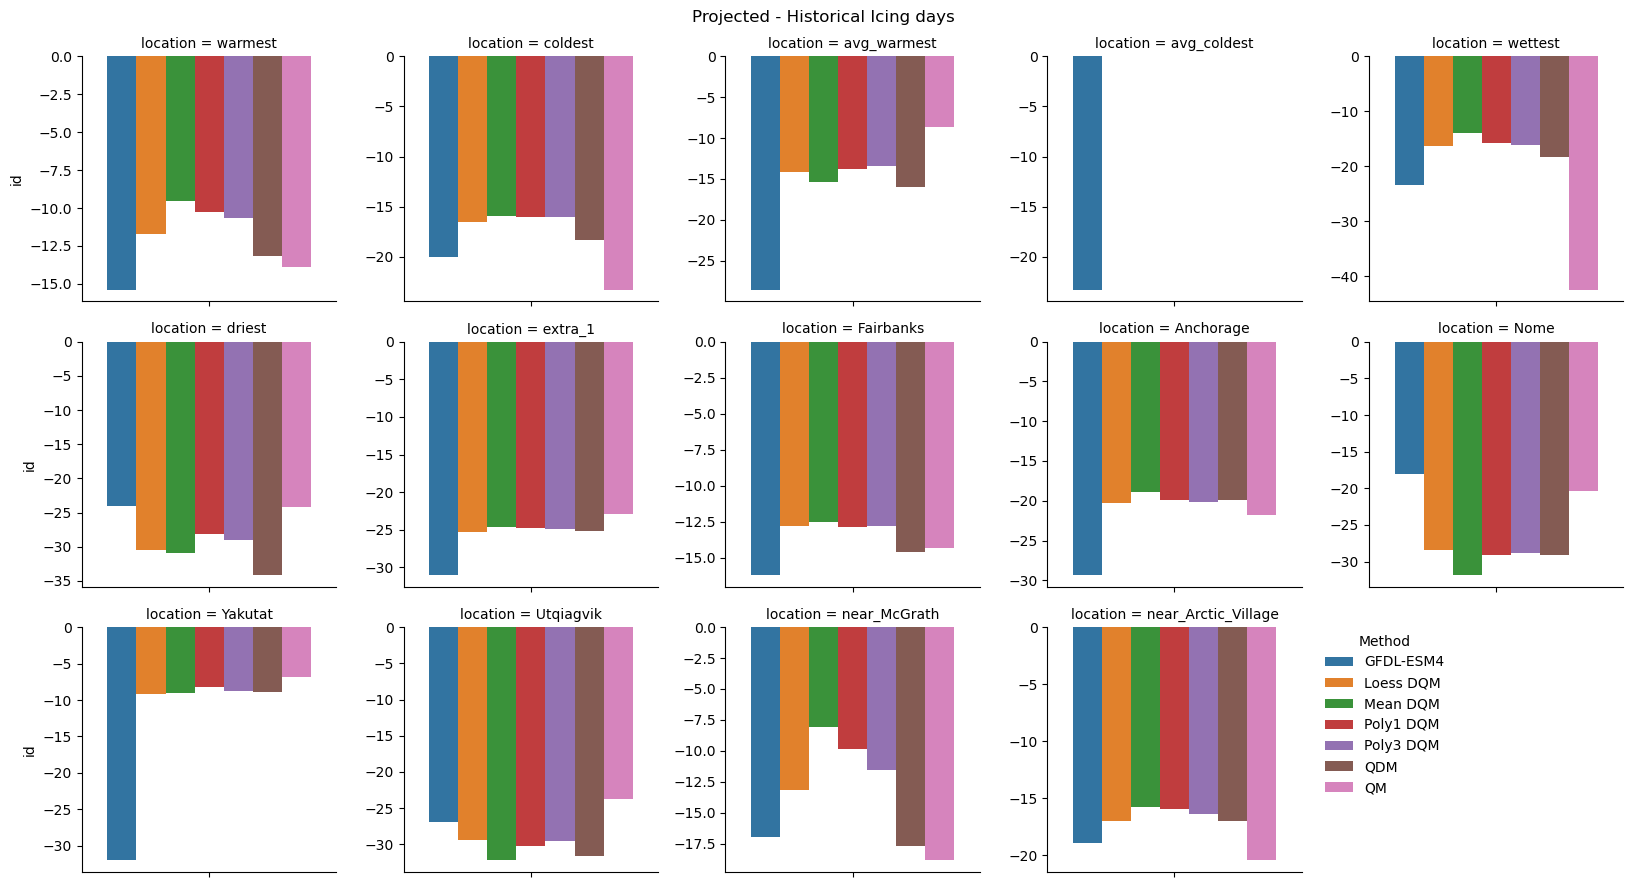

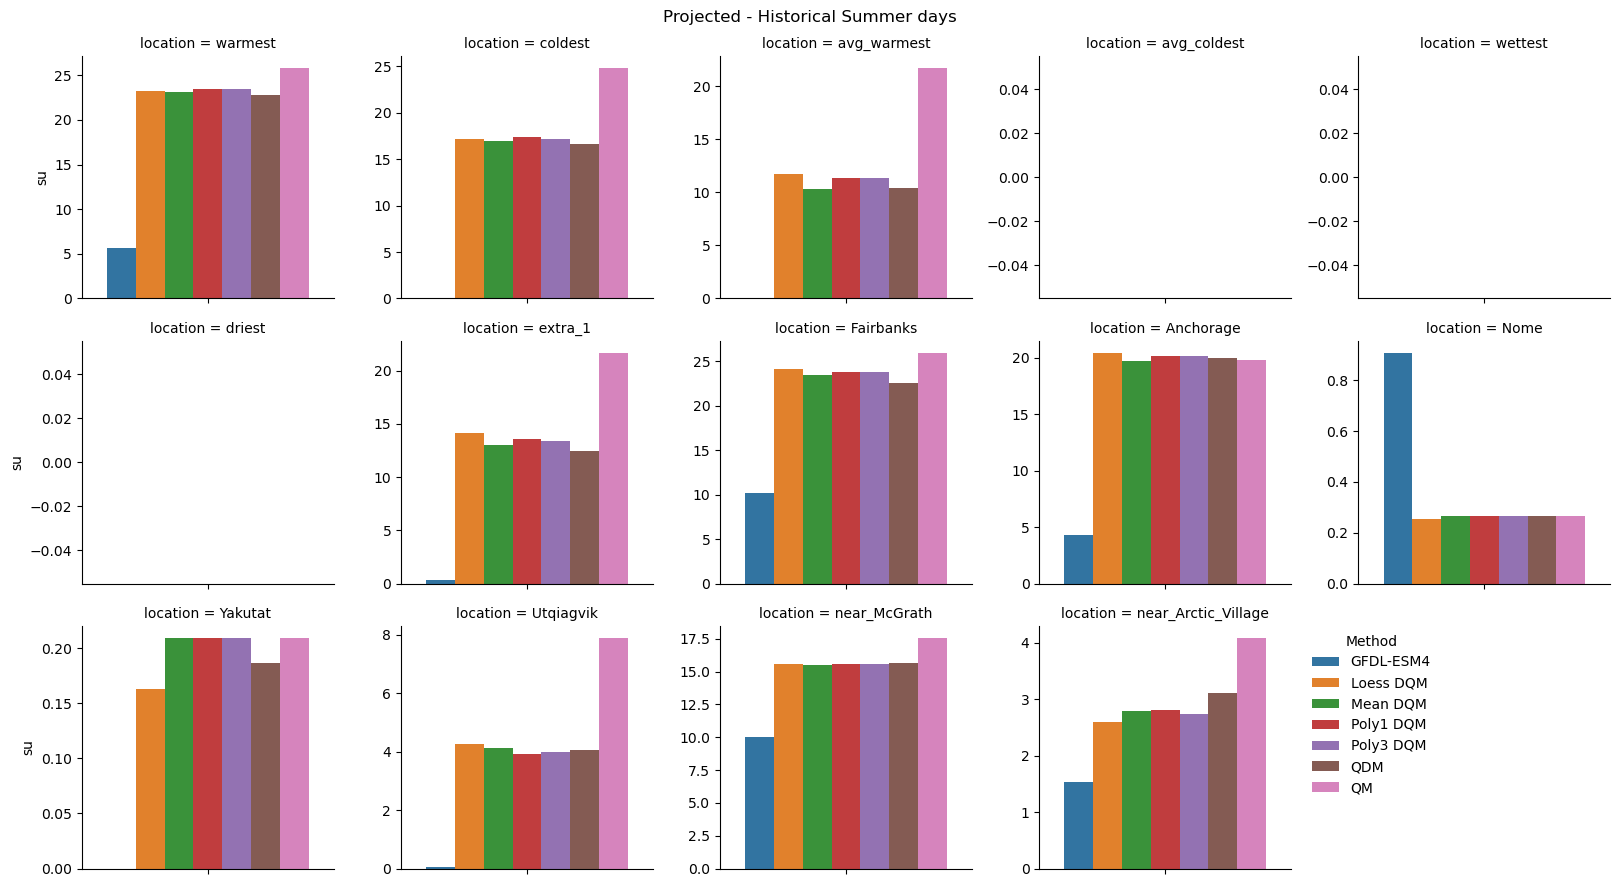

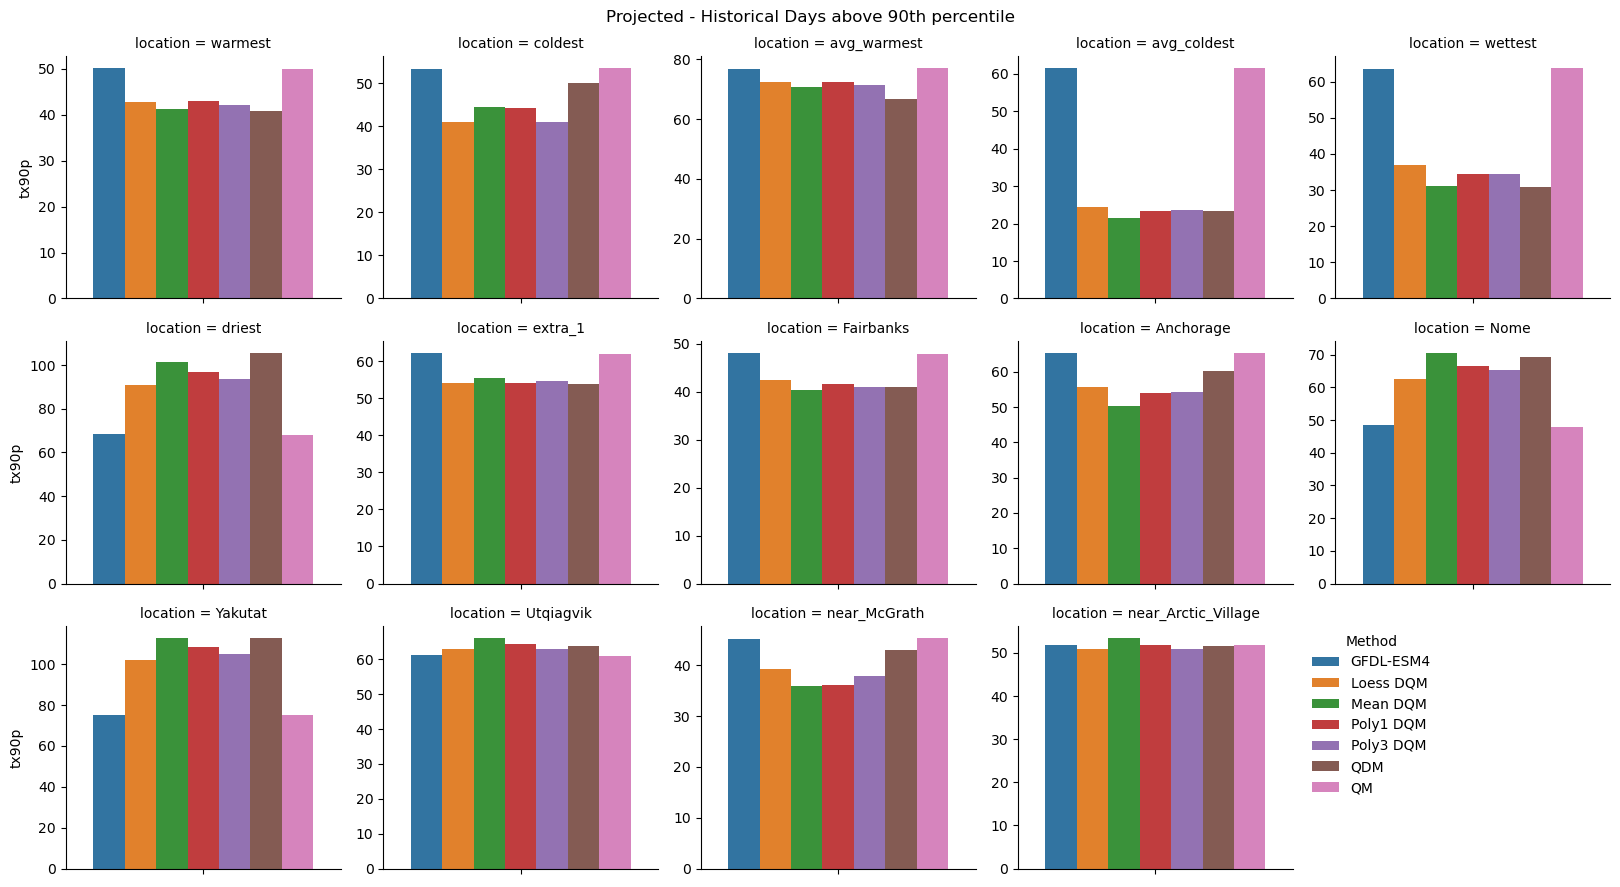

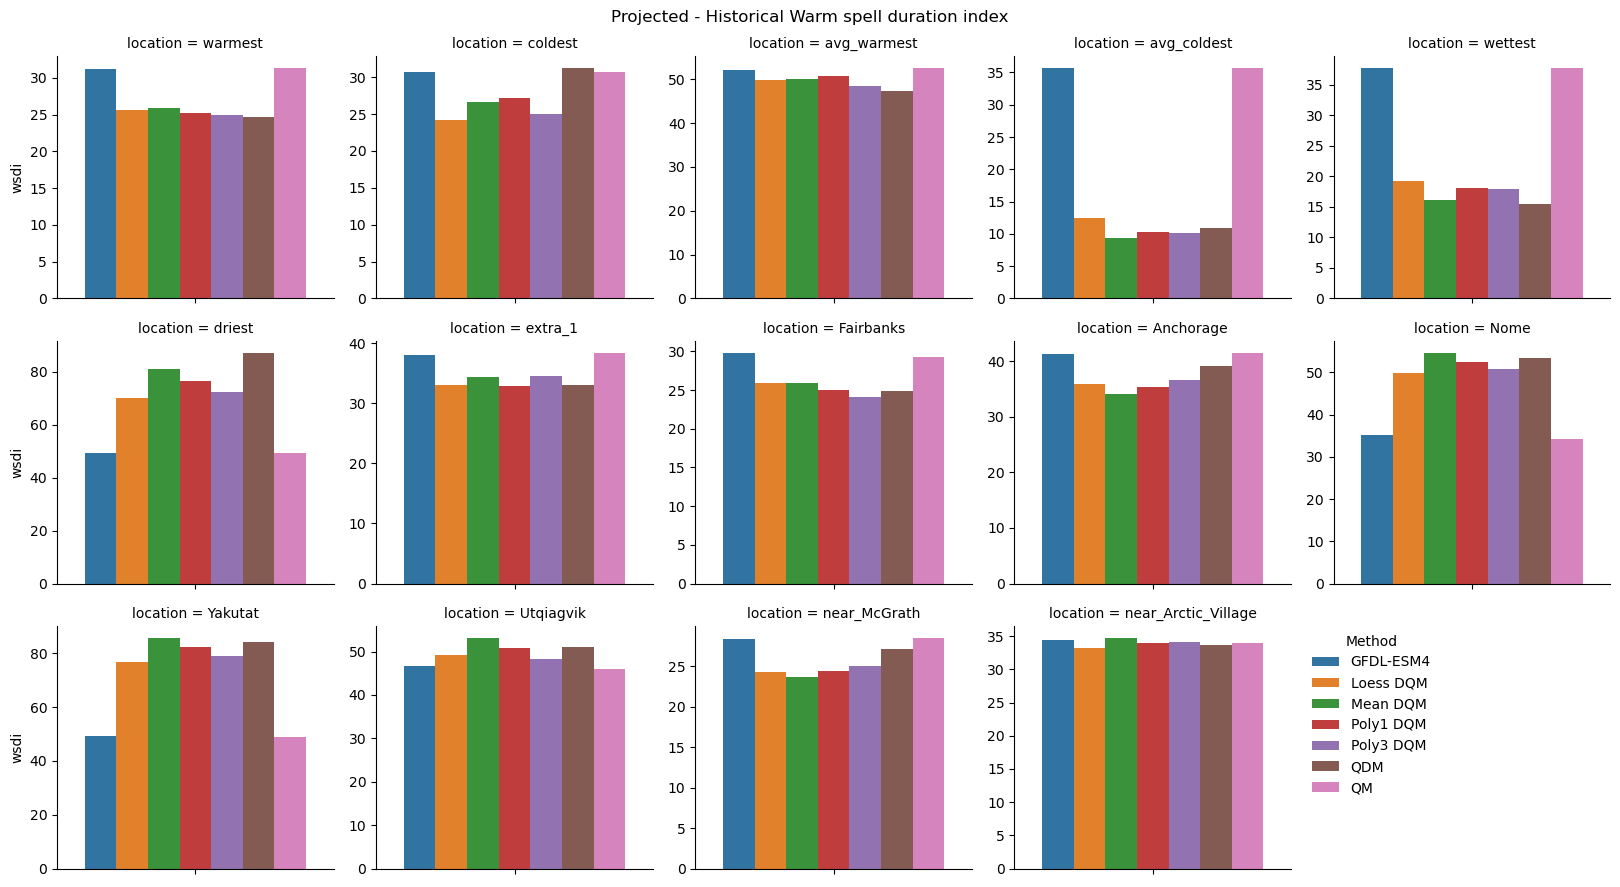

In [24]:
var_id = "tasmax"

hist_indicators = results[model][var_id]["indicators"]["historical"]
proj_indicators = results[model][var_id]["indicators"][scenario]

for indicator in hist_indicators.data_vars:
    baeda.indicator_deltas_by_method_location(
        proj_indicators, hist_indicators, indicator
    )

### Precipitation

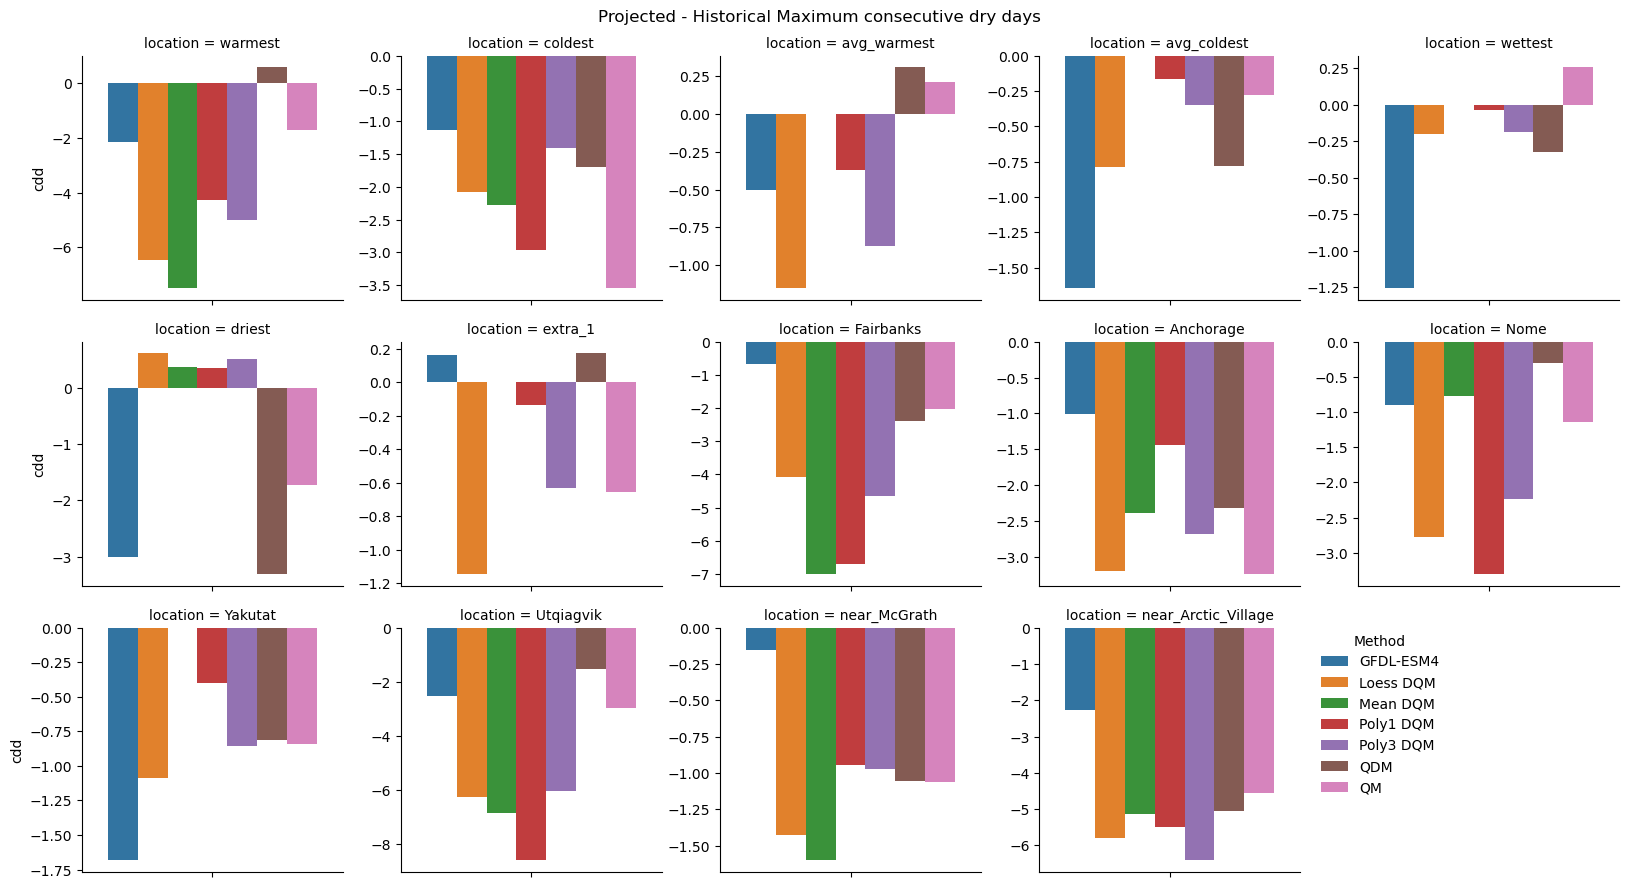

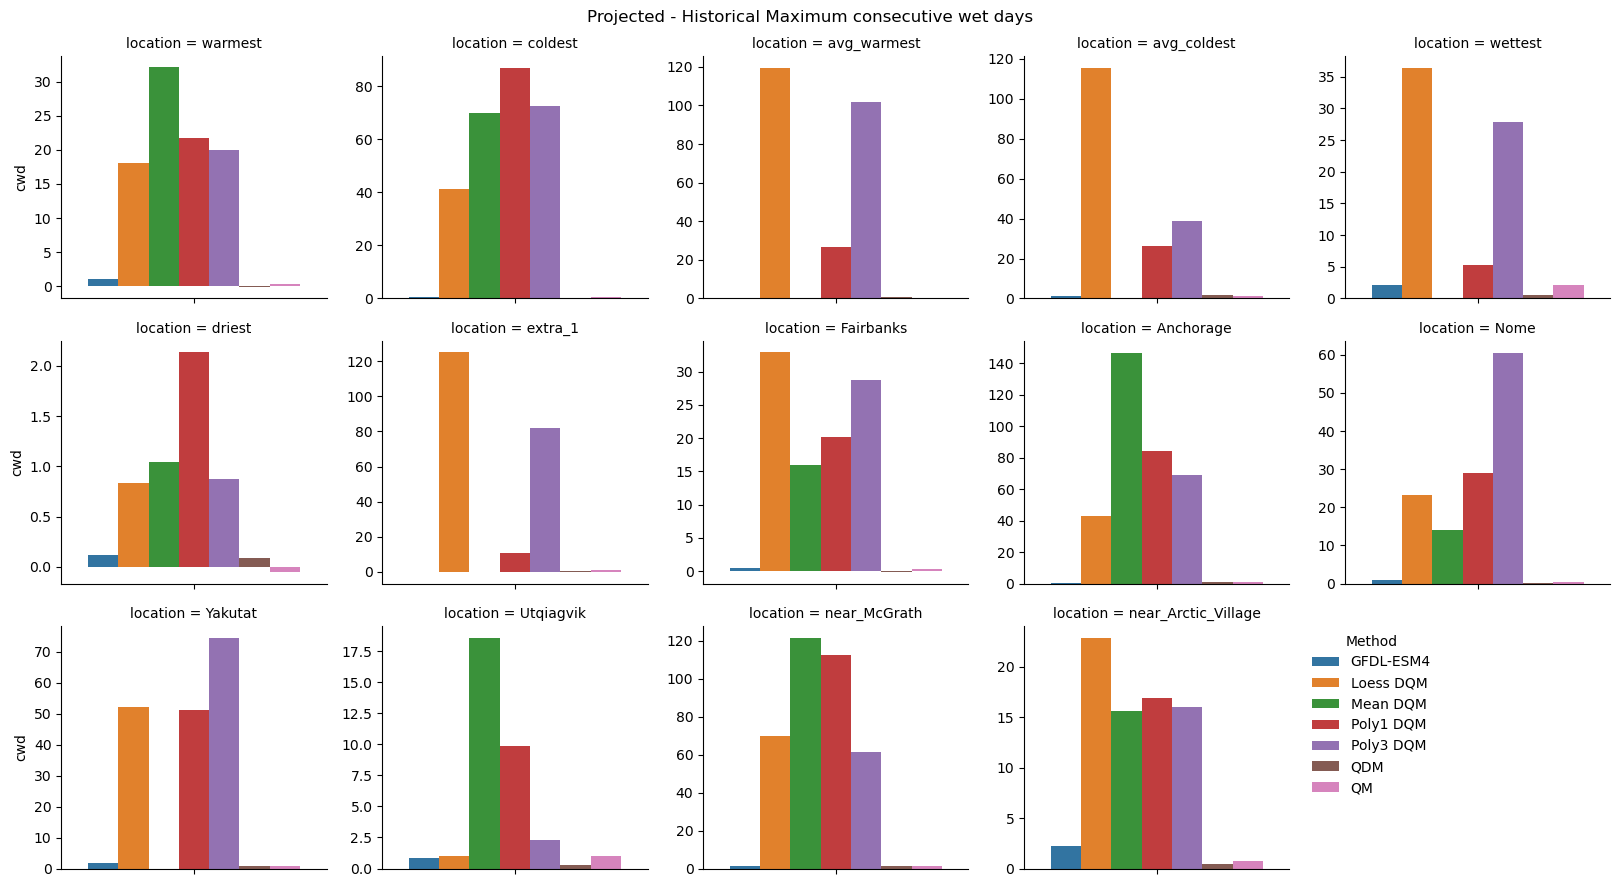

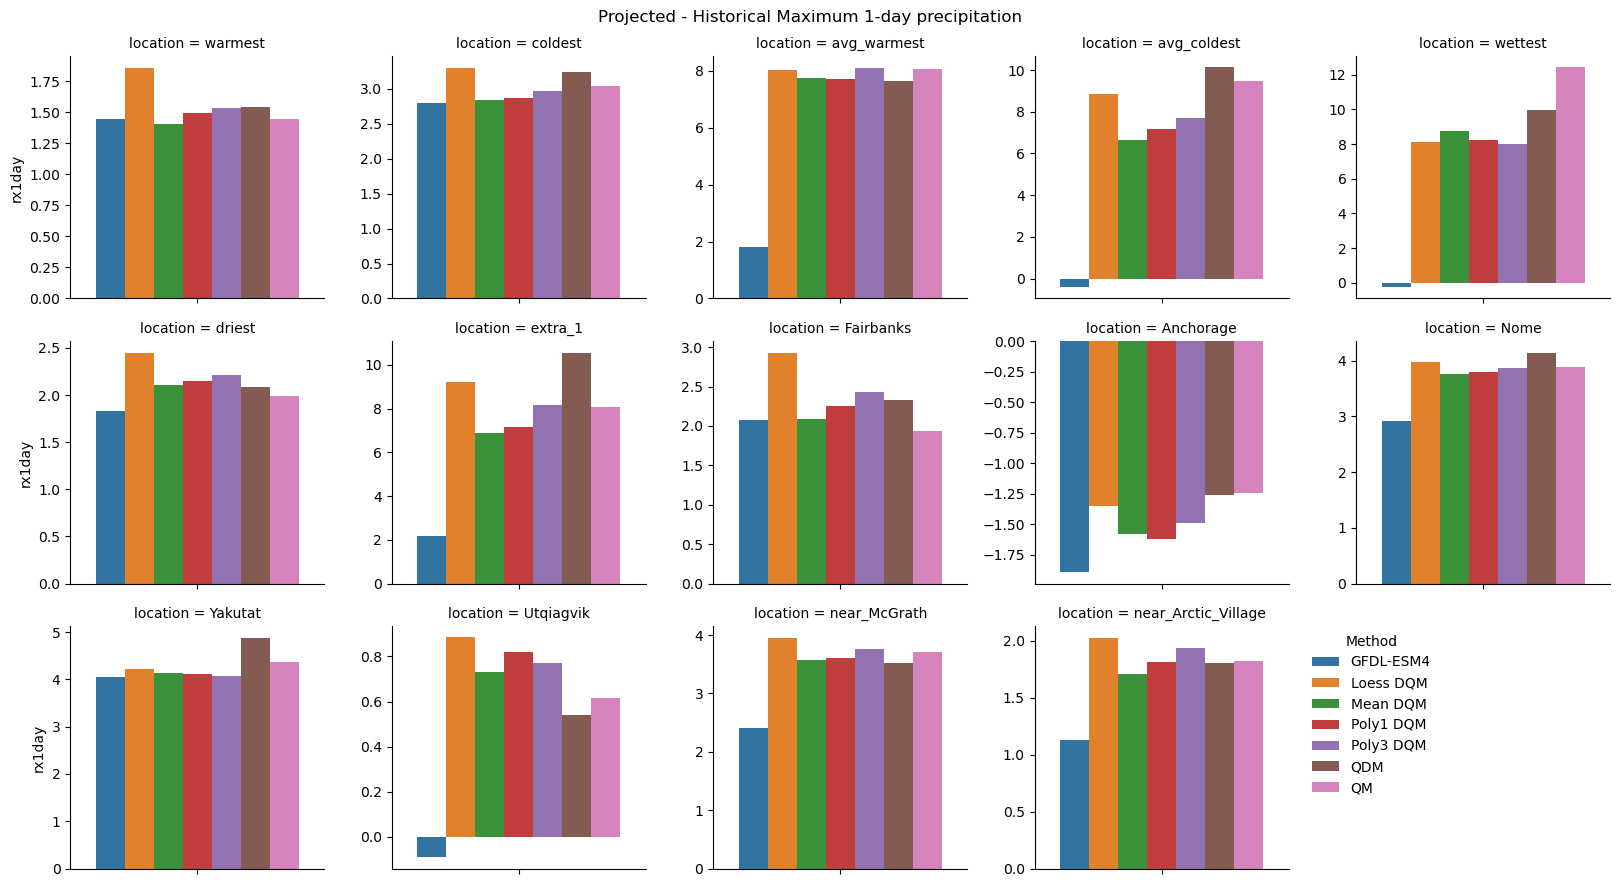

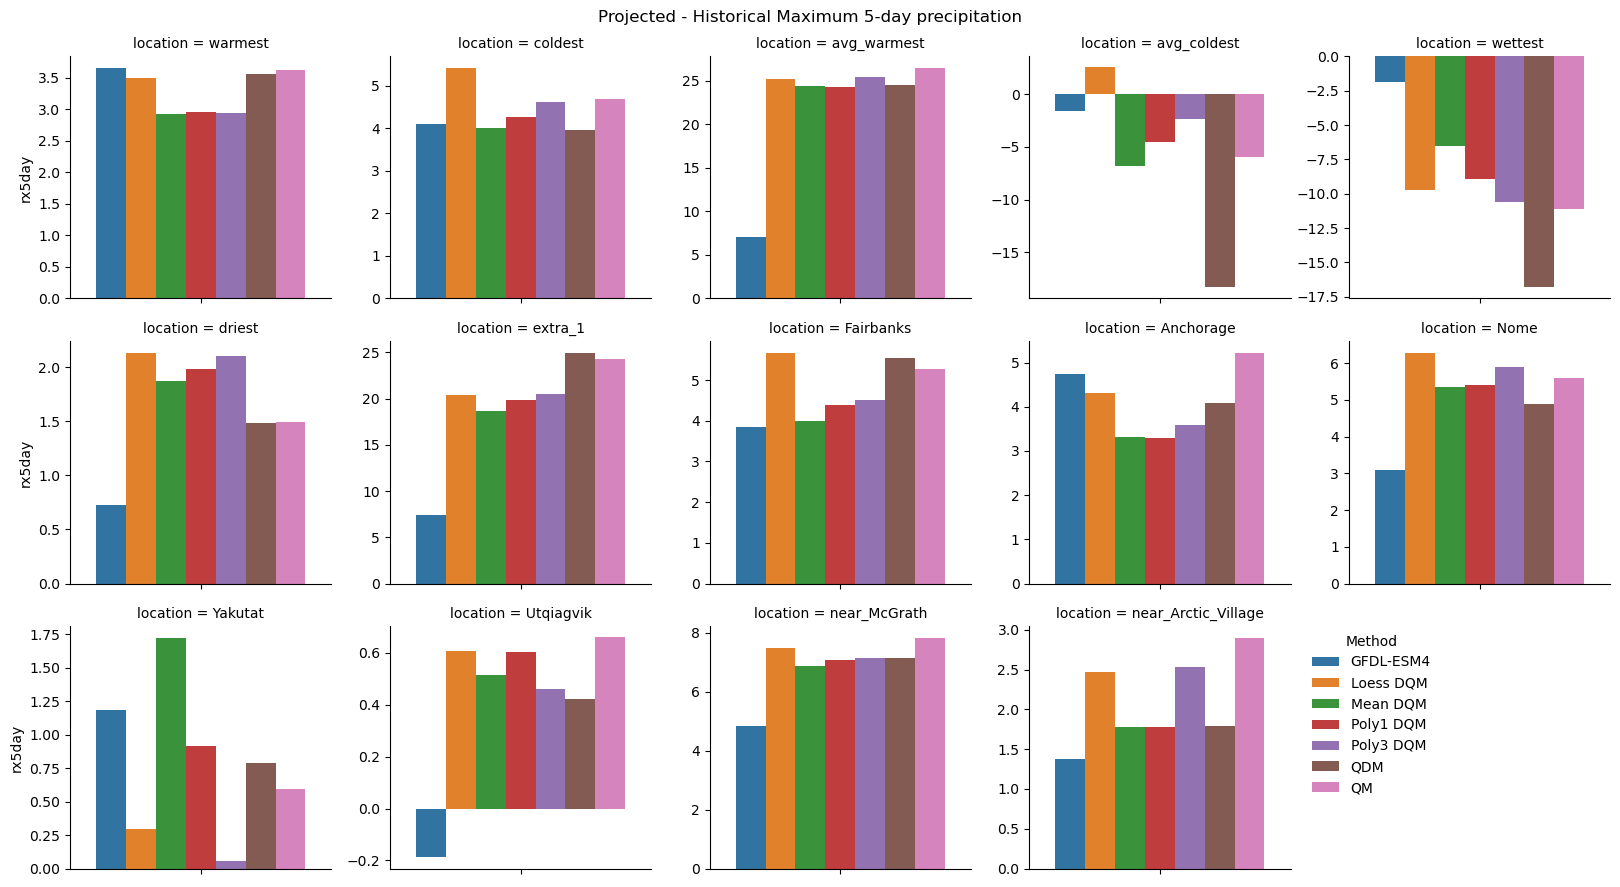

In [25]:
var_id = "pr"

hist_indicators = results[model][var_id]["indicators"]["historical"]
proj_indicators = results[model][var_id]["indicators"][scenario]

for indicator in hist_indicators.data_vars:
    baeda.indicator_deltas_by_method_location(
        proj_indicators, hist_indicators, indicator
    )